# MTH416_FinalProject

## Q1 Implement Convolutional Neural Network  for the classification of the clinical disease

首先，让我们导入需要的包

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import numpy as np

我们需要查看图片，所以我们使用PIL包来读取图片进行绘图，查看数据集的基本情况。

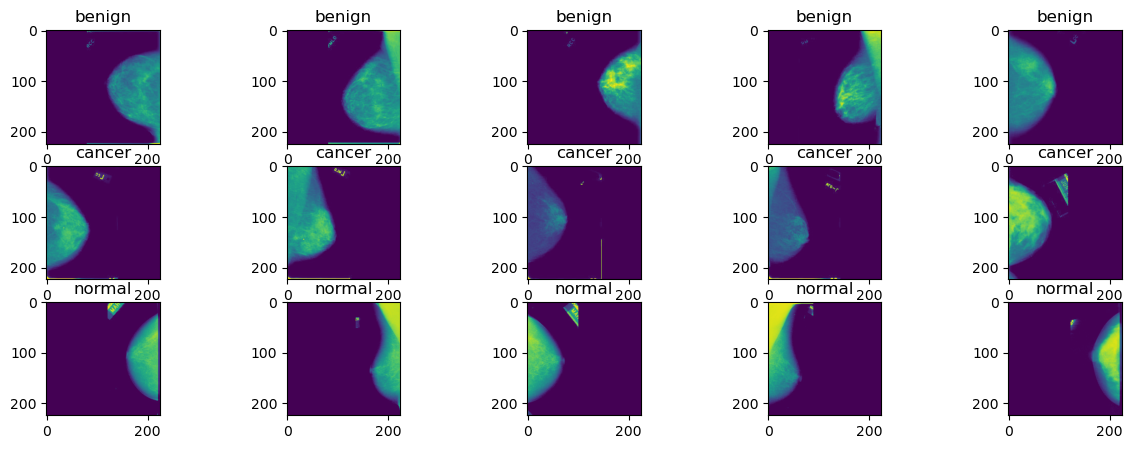

In [2]:
import matplotlib.pyplot as plt
import os
from PIL import Image
labels=['benign', 'cancer', 'normal']
plt.figure(figsize=(15, 5))
for i, class_name in enumerate(labels):
    class_path = os.path.join('train/', class_name)
    image_files = os.listdir(class_path)[:5]  #Take the first 5 image
        
    for j, img_file in enumerate(image_files):
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path)
        ax = plt.subplot(3, 5, i*5 + j + 1)
        plt.imshow(img)
        plt.title(class_name)
plt.show()


我们可以发现这是一个医学影像数据集的分类任务。之后我们需要将图片数据打上对应的标签并读取进来对模型进行训练。首先我们获取train、test、val三个文件夹中的jpg文件路径，并根据它们所在的子文件夹(benign, cancer, normal)打上标签，最后生成一个包含文件路径和标签的列表以方便后续的操作.

注意,下载的test文件中有个文件名为'malignant',和其他文件中的'cancer'含义近似,所以我统一改为cancer。

In [3]:
import os

def get_labeled_data_paths(base_dir):
    data = []
    #Divide the dataset and the labels
    datasets = ['train', 'test', 'val']
    label = {
        'normal': 0,
        'benign': 1,
        'cancer': 2
    }
    for i in datasets:
        path = os.path.join(base_dir, i)
        #get all subdirectories under this path
        for label_name, label_id in label.items():
            label_dir = os.path.join(path, label_name)
            #read all the jpg files under this lable
            for file_name in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file_name)
                data.append([file_path, label_id])
    return data

labeled_data = get_labeled_data_paths('.')
labeled_data

[['.\\train\\normal\\A_0003_1.LEFT_CC.jpg', 0],
 ['.\\train\\normal\\A_0003_1.LEFT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0003_1.RIGHT_CC.jpg', 0],
 ['.\\train\\normal\\A_0003_1.RIGHT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0005_1.LEFT_CC.jpg', 0],
 ['.\\train\\normal\\A_0005_1.LEFT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0005_1.RIGHT_CC.jpg', 0],
 ['.\\train\\normal\\A_0005_1.RIGHT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0006_1.LEFT_CC.jpg', 0],
 ['.\\train\\normal\\A_0006_1.LEFT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0006_1.RIGHT_CC.jpg', 0],
 ['.\\train\\normal\\A_0006_1.RIGHT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0009_1.LEFT_CC.jpg', 0],
 ['.\\train\\normal\\A_0009_1.LEFT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0009_1.RIGHT_CC.jpg', 0],
 ['.\\train\\normal\\A_0009_1.RIGHT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0010_1.LEFT_CC.jpg', 0],
 ['.\\train\\normal\\A_0010_1.LEFT_MLO.jpg', 0],
 ['.\\train\\normal\\A_0010_1.RIGHT_CC.jpg', 0],
 ['.\\train\\normal\\A_0010_1.RIGHT_MLO.jpg', 0],
 ['.\\train\\normal\

之后我们可以根据之前获得的文件路径读取图片并转换为PyTorch Tensor，同时保留标签，构建适合神经网络训练的数据集。我创建了CancerImageDataset类来实现这个功能。其中，data_list是上文包含图像路径和标签的列表，格式为[['path1', label1], ['path2', label2], ...]。然后我们使用了PyTorch的transforms.Compose将多个预处理操作组合成一个流水线，如下所示：

1、将所有输入图像调整为256×256像素,通过查阅资料发现医学图像分类多用256*256的大小，有助于模型发现病灶

2、将PIL图像转换为PyTorch Tensor

3、使用一般的ImageNet的均值和标准差进行归一化，其中mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]



In [4]:
import os
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

#Create the CancerImageDataset class

class CancerImageDataset(Dataset):
    def __init__(self, data_list): #Data Preprocessing
        self.data = data_list
        self.transform = transforms.Compose([
        # Resize The size of the first model is (224, 224).
        # #The subsequent model is of a size of (256, 256), 
        # and here is the data after parameter adjustment.
            transforms.Resize((256, 256)),  
            transforms.ToTensor(),          #turn into Tensor
            transforms.Normalize(          #Normalization
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        # Read the image
        img = Image.open(img_path).convert('RGB')
        # Pre-processing
        img_tensor = self.transform(img)
        # Convert the label to tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return img_tensor, label_tensor

# Get all data paths
data_path_list = get_labeled_data_paths('.')
    
#Divide the training set, validation set and test set
train_data = [item for item in data_path_list if "train" in item[0]]
val_data = [item for item in data_path_list if "val" in item[0]]
test_data = [item for item in data_path_list if "test" in item[0]]
train_dataset = CancerImageDataset(train_data)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
# Create the DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#The DataLoader of the validation set 
#and the test set does not need to be shuffled
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#Test a batch
sample_images, sample_labels = next(iter(train_loader))
print(f"img_tensor_shape: {sample_images.shape}")  # should be [batch_size, 3, 224, 224]
print(f"label_tensor_shape: {sample_labels.shape}")  #should be [batch_size]


img_tensor_shape: torch.Size([32, 3, 256, 256])
label_tensor_shape: torch.Size([32])


这里使用了nn.Sequential()函数来构建网络结构，这样写更加层次更加直观，更加模块化，而且可以单独测试features或classifier的输出。因为我们的训练数据为医学数据，所以可能需要比较复杂的网络结构。所以本报告使用了四层卷积层和三个全连接层，并且使用了两次dropout来随机drop一些节点来防止过拟合。结构如下所示：

conv1()->ReLU()->MaxPooling2d()

conv2()->ReLU()->MaxPooling2d()

conv3()->ReLU()->MaxPooling2d()

conv4()->ReLU()->MaxPooling2d()

Flatten()

linear1()->ReLU()->Dropout()

linear2()->ReLU()->Dropout()

linear3()

其中，特征提取部分有conv1-conv4四层卷积层，第一层使用32个卷积核，224\*224的输入（后调参改为256*256），后面逐步增加至256个卷积核，14\*14的输入。每层卷积层后使用ReLU激活函数，使用MaxPooling2d函数进行池化，池化核大小为2x2，步长为2。Classifier部分有linear1-linear3为三个全连接层，使用ReLU激活函数，使用Dropout函数随机drop 50%的节点来防止过拟合。Dropout应该在激活函数之后，Dropout的目的是随机丢弃神经元的激活值（即ReLU后的输出），而不是原始输入。如果放在Linear之前，可能会影响权重的更新方式，导致训练不稳定。同时，在分类任务中，最后一层（输出层）一般不加Dropout，因为我们需要完整的概率分布做预测。


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import time
from tqdm import tqdm

# Define Neural networks
class CancerImageCNN(nn.Module):
    def __init__(
        self, 
        num_classes=3,
        filter1_size=32,
        filter2_size=64,
        filter3_size=128,
        filter4_size=256,
        fc_1size=256*16*16,  #input is 256x256
        fc_2size=1024,
        fc_3size=512,
        dropout_rate=0.5,
        ):
        super().__init__()
        self.features = nn.Sequential(
            # 输入: 3x256x256
            nn.Conv2d(in_channels=3, 
                      out_channels=filter1_size, 
                      kernel_size=3, 
                      padding=1),  # 32x256x256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 32x128x128
            
            nn.Conv2d(in_channels=filter1_size, 
                      out_channels=filter2_size, 
                      kernel_size=3, 
                      padding=1), # 64x128x128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 64x64x64
            
            nn.Conv2d(in_channels=filter2_size, 
                      out_channels=filter3_size, 
                      kernel_size=3, 
                      padding=1), # 128x64x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 128x32x32
            
            nn.Conv2d(in_channels=filter3_size, 
                      out_channels=filter4_size, 
                      kernel_size=3, 
                      padding=1), # 256x32x32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)        # 256x16x16
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(fc_1size, fc_2size),
            nn.ReLU(inplace=True),
            #Randomly discarding 50% of the neurons can reduce overfitting
            nn.Dropout(p=dropout_rate),
            nn.Linear(fc_2size, fc_3size),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate), 
            nn.Linear(fc_3size, num_classes))
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  #flatten
        # It can also be written like this: 
        # x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')
mynet = CancerImageCNN().to(device)
mynet(torch.randn(32, 3, 256, 256, device=device)).shape 
# The result should be torch.Size([32, 3])

torch.Size([32, 3])

构建完网络之后我们可以开始构建训练和测试函数。首先，我们需要定义训练函数，该函数将训练网络并返回记录在history中的训练损失和验证损失，并提供训练集准确率和验证集准确率。其中，在编写evaluate函数时，我们使用了model.eval()这个方法，目的是puts the network in eval mode. this is important when the network has layers that behaves differently in training and evaluation time, 主要为 dropout and batch norm.

In [6]:
#Training Function and Evaluation Function
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    batches = tqdm(train_loader, desc=f'Train Epoch {epoch}')
    for images, labels in batches:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        #Select the category with the largest value as the prediction
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        batches.set_postfix({
            'loss': running_loss/(total/images.size(0)),
            'acc': 100.*correct/total
        })
    
    train_loss = running_loss/len(train_loader)
    train_acc = 100.*correct/total
    return train_loss, train_acc

def evaluate(model, device, dataloader, criterion):
    model.eval() # puts the network in eval mode. this is important when the
    # network has layers that behaves differently in training and
    # evaluation time, e.g., dropout and batch norm.
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss/len(dataloader)
    val_acc = 100.*correct/total
    return val_loss, val_acc


然后我们需要定义一个预测函数来获取预测的标签，我们需要获取predictions，true_labels，probabilities（使用softmax函数来计算概率），并将这三个数据写入字典中，便于后续对于混淆矩阵和Precision-Recall曲线的绘制。

In [7]:
################################################
def get_predictions(model, device, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return {
        'predictions': np.array(all_preds),
        'true_labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
    }
#### The above is for the convenience of subsequent plotting, 
#### predictions are used for the confusion matrix, 
#### and probabilities are used for the roc curve

接下来我们来构建绘图函数，进行准确率曲线和损失曲线的绘制，读取卷积神经网络中保存历史的train_loss，val_loss，train_acc和val_acc来绘制即可。

In [8]:
#plot part
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

## Q3
这里先进行Q3的原因是想要先调试好一个模型达到最佳，然后再在同样的参数和处理的环境下进行两个模型的对比，所以Q2将会在后面完成

由于我们的数据属于非平衡数据，cancer这个分类的图片数量占比非常少，导致一般的精度会导致误判，所以我们需要绘制混淆矩阵和Recall-Precision曲线，以更准确的评估模型的性能。

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. 
Precision ($P$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false positives ($F_p$).

$$P=\frac{T_p}{T_p+F_p} $$

 
Recall ($R$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false negatives ($F_n$).
$$R=\frac{T_p}{T_p+F_n} $$

The precision-recall curve shows the tradeoff between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision. High precision is achieved by having few false positives in the returned results, and high recall is achieved by having few false negatives in the relevant results. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all relevant results (high recall).

因为我们更加关注cancer的分类的精度，因为将cancer误判为normal的影响非常严重，对于病人的治疗损害非常大，所以是否能将cancer分类的精度提高是非常重要的。为了防止单纯根据精度判断导致的误判，我们将绘制cancer与normal的precision-recall curve。
本报告使用了sklearn.metrics包中的PrecisionRecallDisplay, average_precision_score两个包来绘制precision-recall curve.但是由于本模型为多分类问题，绘制PrecisionRecall时需要将多分类问题转换为二分类问题。需要进行一些处理，将当前类别设定为正类1，其他类别为负类0.函数的构建如下所示：

**参考网址**:https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [9]:
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
import matplotlib.pyplot as plt

def plot_multiclass_pr_curves(y_true, y_scores, class_names, focus_class=None):
    plt.figure(figsize=(12, 10))
    ax = plt.gca()  #Obtain the current axes item
    
    # Draw all category curves
    ap_scores = {}
    for i, name in enumerate(class_names):
        # Convert a multi-classification problem into a binary classification 
        # problem: The current category is positive class 1, 
        # and other categories are negative class 0
        y_true_binary = (y_true == i).astype(int)
            
        ap = average_precision_score(y_true_binary, y_scores[:, i])
        ap_scores[name] = ap
        
        # Set the color:
        # If it is focus_class, use red; otherwise, use the default color
        color = 'red' if (focus_class and name == focus_class) else None
        
        PrecisionRecallDisplay.from_predictions(
            y_true_binary,
            y_scores[:, i],
            name=f'{name} (AP={ap:.2f})',
            ax=ax, 
            color=color,
            plot_chance_level=(i==2),  #Draw the chance level curve of the cancer class
            linewidth=2
        )
    
    plt.title('Multiclass Precision-Recall Curves')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

在定义完以上函数后，我们开始定义完整的主训练流程。首先我们要对模型进行初始化，不然每次调节参数后都会在之前的基础上继续训练。
我们的损失函数选择CrossEntropyLoss，优化器选择Adam，学习率设置为0.001。Adam优化器既可以加速优化，又可以自动调整学习率，对于深度学习模型的优化效果较好。


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd


# Main Training Process
def main():
    # set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    #Initialize the model
    model = CancerImageCNN(num_classes=3).to(device)
    
    #Define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    #List of training records
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    #Training parameters

    epochs_num = 15
    best_acc = 0.0

    # Training epoches
    for epoch in range(1, epochs_num+1):
        start_time = time.time()
        
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        
        # Record historical training 
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save the best model locally
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch}/{epochs_num} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 60)
    
    # testset test
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    print(f'\nFinal Test Performance:')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    
    # Draw the curve of training and validation accuracy and loss
    plot_training_curves(history)
    
    #Draw the confusion matrix and recall rate 
    #related to the prediction results
    test_results = get_predictions(model, device, test_loader)
    y_true = test_results['true_labels']  # true label group
    y_pred = test_results['predictions']  # prediction label group
    classes = ['normal','benign','cancer']  # name of classes
    cm = confusion_matrix(y_true, y_pred)  # confusion matrix
    df_cm = pd.DataFrame(cm) 
    
    print("confusion matrix: \n", df_cm,"col:true label, row:predicted label")
    
    #Draw the PR curve for each category
    #Pay special attention to the cancer category
    y_scores = test_results['probabilities']
    plot_multiclass_pr_curves(y_true, y_scores, classes, focus_class='cancer')

Using device: cuda


Train Epoch 1: 100%|██████████| 77/77 [00:15<00:00,  4.95it/s, loss=0.449, acc=86.4]


Epoch 1/15 | Time: 17.44s
Train Loss: 0.4637 | Train Acc: 86.44%
Val Loss: 0.4816 | Val Acc: 88.12%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 77/77 [00:14<00:00,  5.15it/s, loss=0.412, acc=87.4]


Epoch 2/15 | Time: 16.13s
Train Loss: 0.4251 | Train Acc: 87.37%
Val Loss: 0.5796 | Val Acc: 88.12%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 77/77 [00:15<00:00,  5.09it/s, loss=0.384, acc=87.8]


Epoch 3/15 | Time: 16.92s
Train Loss: 0.3958 | Train Acc: 87.78%
Val Loss: 0.4429 | Val Acc: 90.10%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 77/77 [00:15<00:00,  5.12it/s, loss=0.361, acc=87.8]


Epoch 4/15 | Time: 16.20s
Train Loss: 0.3721 | Train Acc: 87.82%
Val Loss: 0.5208 | Val Acc: 90.10%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 77/77 [00:15<00:00,  5.12it/s, loss=0.349, acc=88]  


Epoch 5/15 | Time: 16.21s
Train Loss: 0.3600 | Train Acc: 88.02%
Val Loss: 0.3734 | Val Acc: 89.44%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 77/77 [00:15<00:00,  5.11it/s, loss=0.302, acc=88.9]


Epoch 6/15 | Time: 16.24s
Train Loss: 0.3119 | Train Acc: 88.92%
Val Loss: 0.4881 | Val Acc: 90.10%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 77/77 [00:15<00:00,  5.10it/s, loss=0.304, acc=89.3]


Epoch 7/15 | Time: 16.27s
Train Loss: 0.3135 | Train Acc: 89.28%
Val Loss: 1.9601 | Val Acc: 88.12%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 77/77 [00:15<00:00,  5.04it/s, loss=0.273, acc=90.8]


Epoch 8/15 | Time: 17.08s
Train Loss: 0.2814 | Train Acc: 90.82%
Val Loss: 0.3146 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 77/77 [00:14<00:00,  5.14it/s, loss=0.209, acc=92]  


Epoch 9/15 | Time: 16.15s
Train Loss: 0.2160 | Train Acc: 92.04%
Val Loss: 0.3839 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 77/77 [00:15<00:00,  5.09it/s, loss=0.169, acc=93.9]


Epoch 10/15 | Time: 16.91s
Train Loss: 0.1746 | Train Acc: 93.87%
Val Loss: 0.2762 | Val Acc: 91.09%
------------------------------------------------------------


Train Epoch 11: 100%|██████████| 77/77 [00:15<00:00,  5.06it/s, loss=0.112, acc=95.7]


Epoch 11/15 | Time: 17.01s
Train Loss: 0.1152 | Train Acc: 95.66%
Val Loss: 0.2986 | Val Acc: 92.41%
------------------------------------------------------------


Train Epoch 12: 100%|██████████| 77/77 [00:15<00:00,  5.10it/s, loss=0.143, acc=95.3]


Epoch 12/15 | Time: 16.27s
Train Loss: 0.1480 | Train Acc: 95.29%
Val Loss: 0.3141 | Val Acc: 92.41%
------------------------------------------------------------


Train Epoch 13: 100%|██████████| 77/77 [00:15<00:00,  5.12it/s, loss=0.0802, acc=97.2]


Epoch 13/15 | Time: 16.21s
Train Loss: 0.0828 | Train Acc: 97.24%
Val Loss: 0.4667 | Val Acc: 92.08%
------------------------------------------------------------


Train Epoch 14: 100%|██████████| 77/77 [00:15<00:00,  5.02it/s, loss=0.0672, acc=97.4]


Epoch 14/15 | Time: 16.53s
Train Loss: 0.0694 | Train Acc: 97.36%
Val Loss: 0.4186 | Val Acc: 92.08%
------------------------------------------------------------


Train Epoch 15: 100%|██████████| 77/77 [00:15<00:00,  5.12it/s, loss=0.0837, acc=97.2]


Epoch 15/15 | Time: 16.23s
Train Loss: 0.0864 | Train Acc: 97.24%
Val Loss: 0.4211 | Val Acc: 90.43%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_3532\3929769528.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.3931 | Test Acc: 92.13%


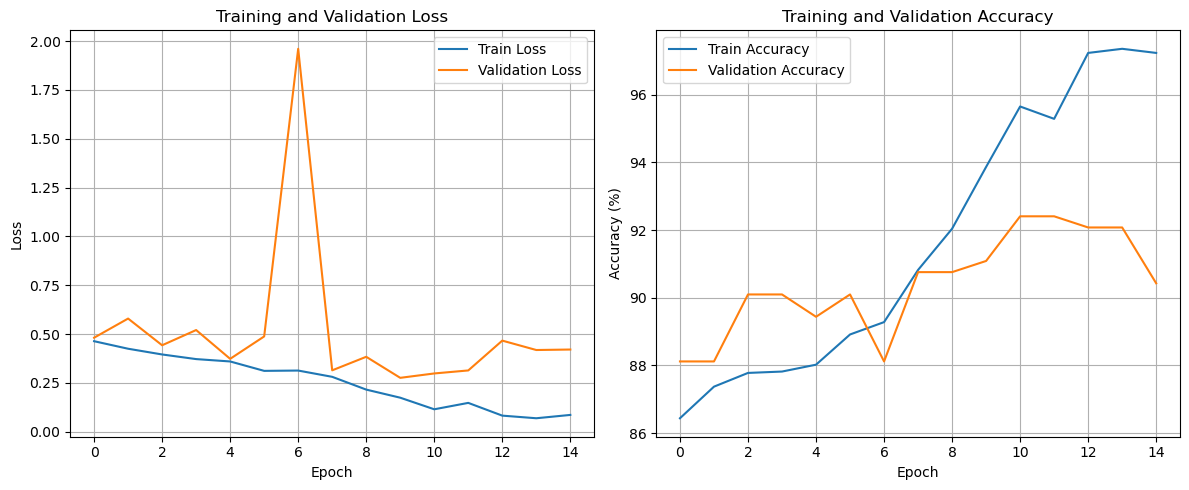

原始混淆矩阵：
      0   1  2
0  265   2  0
1    6  10  4
2    6   6  6 其中列为true label,行为predicted label


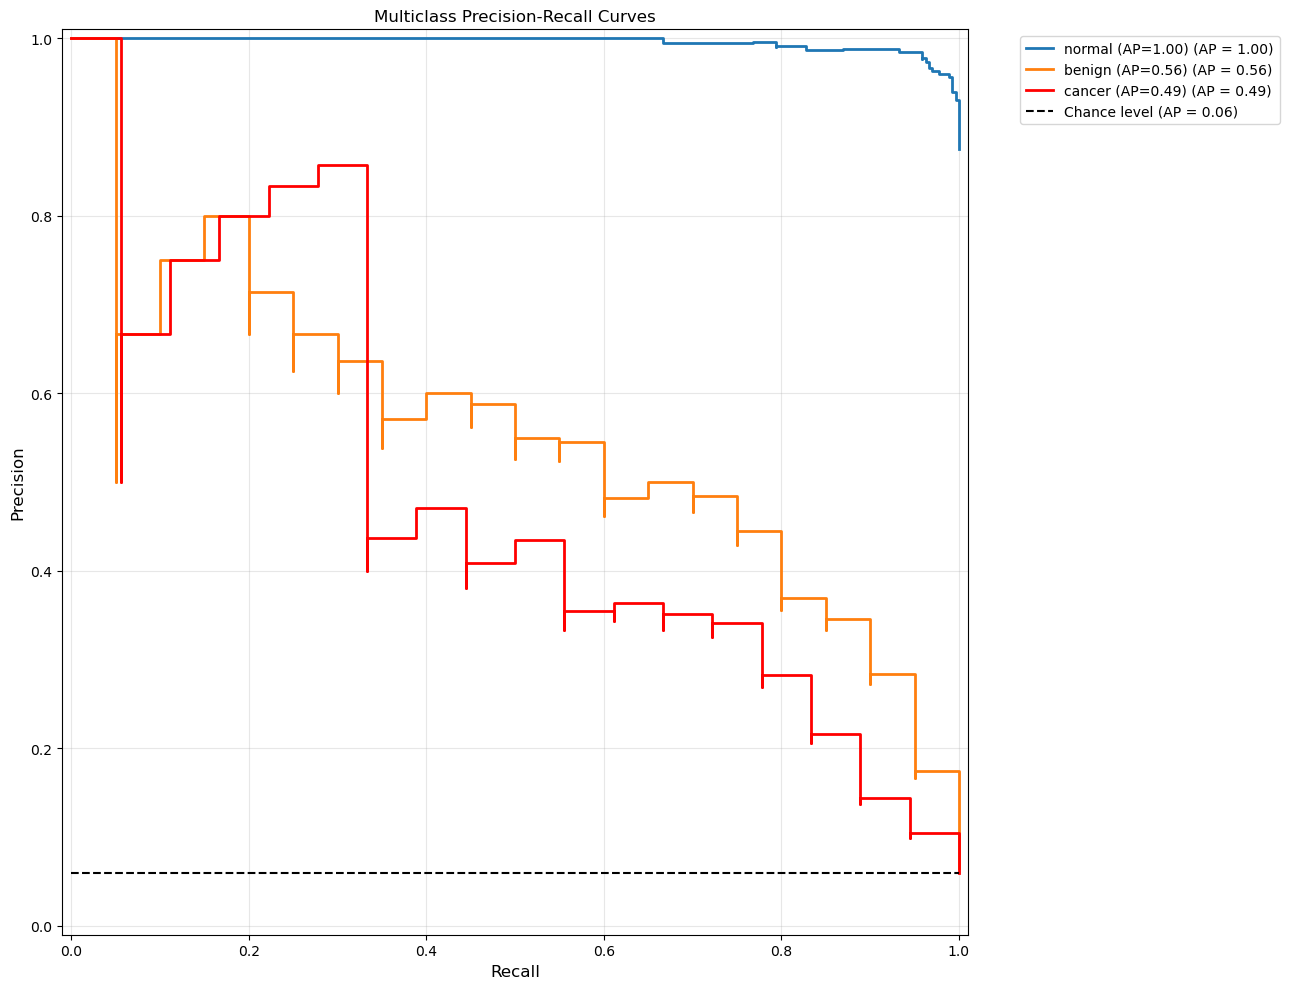

In [10]:
if __name__ == "__main__":
    main()


从上述结果可以看出模型的train accuracy 最高达到了97%.但是验证集和测试集的准确性却很低，validation accuracy最高为92%。测试集准确率也仅有92%左右。从验证集和训练集的损失曲线和准确率曲线可以看出，验证集的损失曲线在训练次数上升后也在随之上升，伴随着准确率的震荡，这说明模型对于训练集过拟合了，导致其在测试集和验证集上效果很差。并且从PrecisionRecall图可以看出，cancer类别的recall比noramal低很多。从混淆矩阵中，我们可以看出，测试集中三分之一部分的cancer和benign样本被误判为normal类别。将cancer类别误判为normal的类别造成的后果将是严重的，所以我们主要需要解决这个问题。模型训练数据为非平衡数据会导致准确率的误判，所以我们需要扩充数据集，可以通过过采样等方式来平衡样本等或对模型进行加权等方式来解决这个问题。

## Q4. Improving Class Imbalance

所以我们计划做出以下两个改进来解决类别不平衡问题：

1、在损失函数中添加权重

2、通过过采样等方式增加cancer样本数量。

我们选择通过过采样的方式增加cancer的样本数量，并网络中的损失函数添加权重。我们可以为normal样本赋予较小的权重，而为cancer样本赋予较大的权重。这样可以使得模型更加关注cancer样本的预测准确率。同时也可以适当增加benign类的样本数量平衡样本，因为benign样本数量也较少。于是我们更改网络结构和主要训练流程，改动如下所示：

1、将所有输入图像调整为256×256像素,通过查阅资料发现医学图像分类多用256*256的大小，有助于模型发现病灶

2、我们修改数据集，对cancer和benign样本进行过采样，使得cancer样本数量扩大至原先的10倍，benign样本数量扩大为原来的五倍。原本有132个cancer样本和186个benign样本，现在分别扩充至1320个和930个。

3、在损失函数中添加权重，以便模型更加关注cancer样本的预测准确率。

4、减少了模型的卷积层，因为过多的卷积层会导致模型过拟合。

5、创建了一个创建Learning Rate Scheduler， 使用StepLR来在训练中动态调整学习率。根据指定的规则逐步降低学习率，以帮助模型更好地收敛。参数说明：optimizer：绑定的优化器（如 SGD、Adam 等）。step_size：调整学习率的步长（单位：epoch）; 每经过 step_size 个 epoch，学习率会乘以 gamma; gamma：学习率衰减的乘法因子
经过调试，我们的步长设为5，gamma设定为为0.1，也就是每经过5个epoch，学习率便乘以0.1。

6、增加了batch normalization层，预防可能导致的过拟合现象。


首先我们尝试对测试集进行Use up-sampling to balance the samples in each class。如下所示，我们编写了一个重抽样函数：



    改进的重抽样函数（支持多种医学图像抽样策略）
    
    参数:
        original_data: [(img_path, label), ...] 的列表
        target_class: 需要过采样的目标类别（如癌症类别）
        multiplier: 目标类别样本量扩大倍数（2表示样本量翻倍）
        mode: 抽样策略 ['random', 'smart', 'gan', 'hybrid']
    
    返回:
        重抽样后的数据集列表

In [11]:
import random
import numpy as np
from torchvision import transforms
from collections import Counter

def create_oversampled_dataset(original_data, target_class, multiplier):
    # Separate the target class and non-target class samples
    target_samples = [item for item in original_data if item[1] == target_class]
    non_target_samples = [item for item in original_data if item[1] != target_class]
    
    #count the original_target
    original_target_count = len(target_samples)
    
    # Basic random oversampling (with replacement)
    new_target_samples = random.choices(
        target_samples, 
        k=original_target_count * (multiplier - 1)
        )
    # Merge the new and old samples
    oversampled_data = non_target_samples + target_samples + new_target_samples
    # Verify the sampling count
    print(f"Aftrer oversampleing: {Counter([d[1] for d in oversampled_data])}")
    return oversampled_data

##The sample size of the cancer category is very small and the 
#judgment accuracy is very important. 
# Therefore, oversampling of this category is conducted first to 
# expand the sample to 10 times the original size
train_data_oversampled=create_oversampled_dataset(train_data,2,multiplier=10)
####At the same time, the sample size of begin is also expanded to 10 folds
train_data_oversampled=create_oversampled_dataset(train_data_oversampled,1,multiplier=10)
# only change the training set
train_dataset_oversampled = CancerImageDataset(train_data_oversampled)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
#Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset_oversampled, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

sample_images, sample_labels = next(iter(train_loader))
print(f"img_tensor_shape: {sample_images.shape}")  #should be [32, 3, 224, 224]
print(f"label_tensor_shape: {sample_labels.shape}")  #should be [32]


Aftrer oversampleing: Counter({0: 2145, 2: 1320, 1: 186})
Aftrer oversampleing: Counter({0: 2145, 1: 1860, 2: 1320})
img_tensor_shape: torch.Size([32, 3, 256, 256])
label_tensor_shape: torch.Size([32])


然后我们更改了模型，删除了一层卷积层，并且添加了batch normalization层。删除卷积层是希望可以通过减少参数来减少过拟合现象，因为复杂的网络有更多的参数，过拟合的风险也会提升。添加batch normalization层的原因是希望通过减少内部协变量偏移来提升模型的泛化能力。

修改后的卷积神经网络结构如下：

conv2()->ReLU()->batch_normalization()->MaxPooling2d()

conv3()->ReLU()->batch_normalization()->MaxPooling2d()

conv3()->ReLU()->->batch_normalization()MaxPooling2d()

Flatten()

linear1()->ReLU()->->batch_normalization()->Dropout()

linear2()->ReLU()->->batch_normalization()->Dropout()

linear3()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import time
from tqdm import tqdm

import torch
import torch.nn as nn

class CancerImageCNN(nn.Module):
    def __init__(
        self, 
        num_classes=3,
        filter1_size=32,
        filter2_size=64,
        filter3_size=128,  # The fourth convolution layer has been removed
        fc_1size=128*32*32,  # Adjust the input size because the last convolution layer has been removed
        fc_2size=1024,
        fc_3size=512,
        dropout_rate=0.5,
        ):
        super().__init__()
        self.features = nn.Sequential(
            # input: 3x256x256
            nn.Conv2d(in_channels=3, 
                      out_channels=filter1_size, 
                      kernel_size=3, 
                      padding=1),  # 32x256x256
            nn.BatchNorm2d(filter1_size),  # add BatchNorm
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 32x128x128
            
            nn.Conv2d(in_channels=filter1_size, 
                      out_channels=filter2_size, 
                      kernel_size=3, 
                      padding=1), # 64x128x128
            nn.BatchNorm2d(filter2_size),  # add BatchNorm
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # 64x64x64
            
            nn.Conv2d(in_channels=filter2_size, 
                      out_channels=filter3_size, 
                      kernel_size=3, 
                      padding=1), # 128x64x64
            nn.BatchNorm2d(filter3_size),  # add BatchNorm
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)       # 128x32x32
            # The fourth convolution layer and pooling layer has been removed
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(fc_1size, fc_2size),
            # BatchNorm is also added after the fully connected layer
            nn.BatchNorm1d(fc_2size),  \
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(fc_2size, fc_3size),
            # BatchNorm is also added after the fully connected layer
            nn.BatchNorm1d(fc_3size), 
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate), 
            nn.Linear(fc_3size, num_classes)
            )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) #flatten
        x = self.classifier(x)
        return x

device = torch.device('cpu')

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')
mynet = CancerImageCNN().to(device)
mynet(torch.randn(32, 3, 256, 256, device=device)).shape 
#should be torch.Size([32, 3])

torch.Size([32, 3])

主要训练过程的改变就是减少了训练轮次，由15次减少到了10次。从之前的训练过程中可以看出，模型在训练十次左右是已经差不多收敛，减少训练轮次不仅减少了训练时间，还有助于防止过拟合。

In [13]:
from sklearn.utils.class_weight import compute_class_weight

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = CancerImageCNN(num_classes=3).to(device)
    
    # Define the loss function and the optimizer
    
    ################## The loss function is weighted here
    # Extract all labels from the training dataset
    def get_all_labels(dataset):
        return [label for _, label in dataset]

    # Get all labels from the training set
    train_labels = get_all_labels(train_dataset)  # Note: using the original training set without resampling
    # If using resampled dataset, the weights would be approximately equal
    ################## Calculate class weights
    # class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=np.array(train_labels))
    ################## Apply weights in the loss function, note: using the original training set
    # criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ################## Use StepLR to dynamically adjust learning rate during training
    scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
    

    # Training history records
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training parameters
    
    ## Debug settings
    epochs_num = 10  # Reduced number of training epochs
    best_acc = 0.0

    # Training loop
    for epoch in range(1, epochs_num+1):
        start_time = time.time()
        
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        scheduler.step()
        
        # Record historical data
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch}/{epochs_num} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 60)
    
    # Final testing
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    print(f'\nFinal Test Performance:')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    
    # Plot training curves
    plot_training_curves(history)
    
    # Plot confusion matrix and recall-related metrics for predictions
    test_results = get_predictions(model, device, test_loader)
    y_true = test_results['true_labels']  # Array of true labels
    y_pred = test_results['predictions']  # Array of predicted labels
    classes = ['normal','benign','cancer']  # Class names
    cm = confusion_matrix(y_true, y_pred)  # Confusion matrix
    df_cm = pd.DataFrame(cm) 
    
    print("Original confusion matrix:\n", df_cm, "where columns are true labels and rows are predicted labels")
    
    # Plot PR curves for each class
    # Special focus on the 'cancer' class
    y_scores = test_results['probabilities']
    plot_multiclass_pr_curves(y_true, y_scores, classes, focus_class='cancer')

Using device: cuda


Train Epoch 1: 100%|██████████| 167/167 [00:39<00:00,  4.21it/s, loss=0.231, acc=75.7]


Epoch 1/10 | Time: 42.19s
Train Loss: 0.5669 | Train Acc: 75.74%
Val Loss: 0.8578 | Val Acc: 88.12%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 167/167 [00:38<00:00,  4.30it/s, loss=0.0697, acc=93.7]


Epoch 2/10 | Time: 40.09s
Train Loss: 0.1709 | Train Acc: 93.71%
Val Loss: 1.3495 | Val Acc: 53.80%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 167/167 [00:39<00:00,  4.28it/s, loss=0.0325, acc=97.1]


Epoch 3/10 | Time: 41.54s
Train Loss: 0.0797 | Train Acc: 97.11%
Val Loss: 0.6127 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 167/167 [00:39<00:00,  4.27it/s, loss=0.0205, acc=98.2]


Epoch 4/10 | Time: 41.58s
Train Loss: 0.0503 | Train Acc: 98.23%
Val Loss: 0.2801 | Val Acc: 94.06%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 167/167 [00:39<00:00,  4.24it/s, loss=0.0209, acc=98.3]


Epoch 5/10 | Time: 40.64s
Train Loss: 0.0512 | Train Acc: 98.29%
Val Loss: 0.3694 | Val Acc: 92.74%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 167/167 [00:39<00:00,  4.21it/s, loss=0.00649, acc=99.5]


Epoch 6/10 | Time: 40.87s
Train Loss: 0.0159 | Train Acc: 99.51%
Val Loss: 0.4032 | Val Acc: 92.74%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 167/167 [00:39<00:00,  4.26it/s, loss=0.00615, acc=99.5]


Epoch 7/10 | Time: 40.43s
Train Loss: 0.0151 | Train Acc: 99.51%
Val Loss: 0.3198 | Val Acc: 93.07%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 167/167 [00:39<00:00,  4.24it/s, loss=0.00202, acc=99.9]


Epoch 8/10 | Time: 41.89s
Train Loss: 0.0050 | Train Acc: 99.92%
Val Loss: 0.2950 | Val Acc: 94.39%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 167/167 [00:39<00:00,  4.19it/s, loss=0.00274, acc=99.7]


Epoch 9/10 | Time: 41.09s
Train Loss: 0.0067 | Train Acc: 99.74%
Val Loss: 0.2898 | Val Acc: 93.73%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 167/167 [00:39<00:00,  4.27it/s, loss=0.00269, acc=99.8]


Epoch 10/10 | Time: 41.60s
Train Loss: 0.0066 | Train Acc: 99.85%
Val Loss: 0.2827 | Val Acc: 94.72%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_17176\418925206.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.5240 | Test Acc: 93.44%


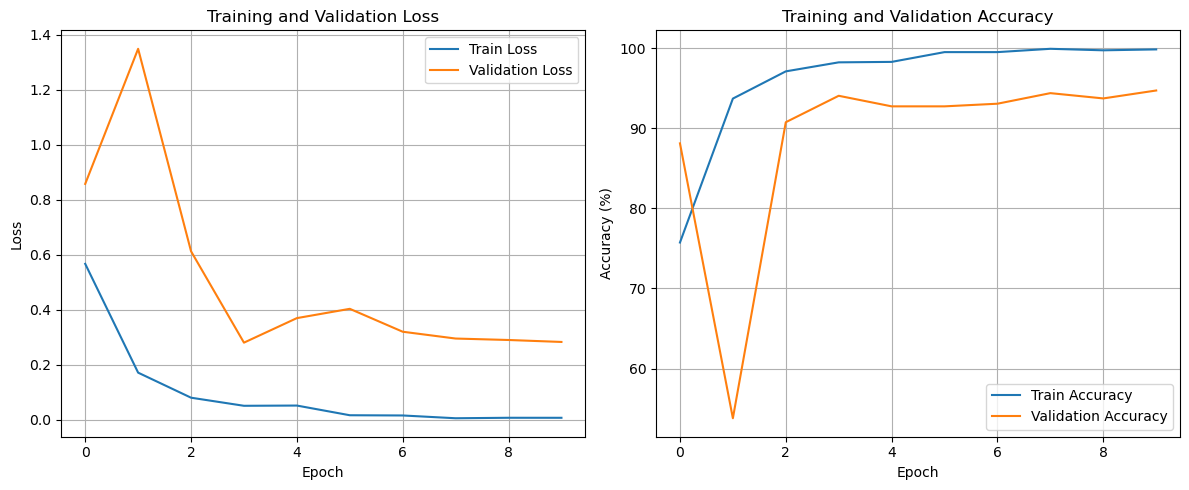

原始混淆矩阵：
      0   1  2
0  265   0  2
1    0  12  8
2    0  10  8 其中列为true label,行为predicted label


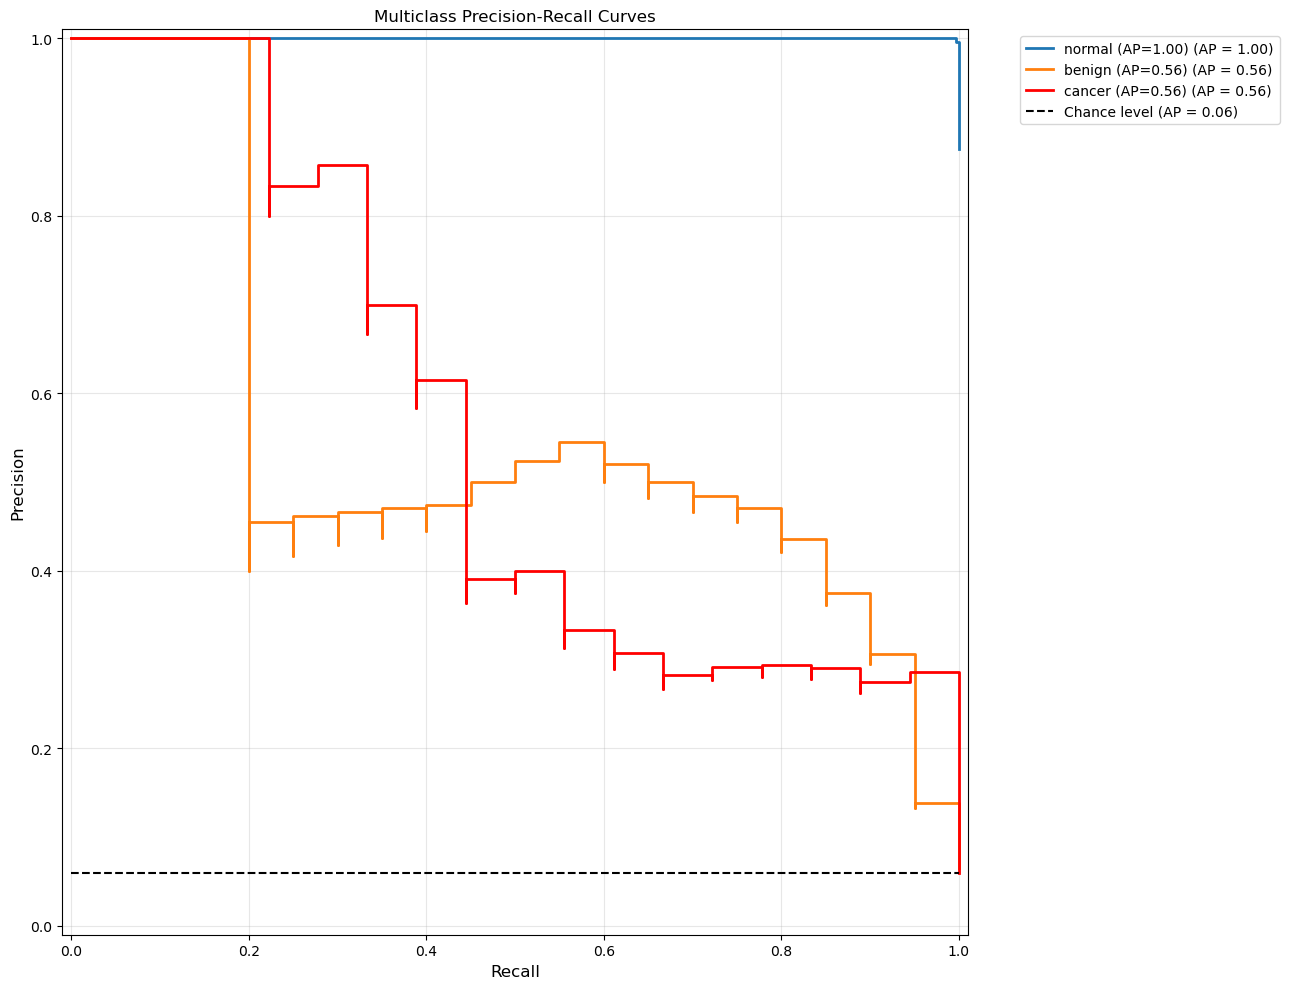

In [14]:
if __name__ == '__main__':
    main()

In [16]:
12/20

0.6

从recall和precision的角度来看，模型的效果有很大改善，准确率提升到了93%，从PR曲线上看，各个类别率召回率也有明显的提升。从混淆矩阵中可以看出，模型对测试集中的cancer样本的预测准确率提升到了8/18=0.44，模型对begign样本的识别率相比之下更高一些达到了12/20=0.6。但总体来说还是不够好，这可能是因为重抽样数量还不够大，模型还没有学到足够的特征，导致的过拟合，模型的泛化能力不足。从混淆矩阵中可以看出，cancer样本多被划分到了begign类中，为了保证高cancer样本的识别率，我们也可以考虑使用更加复杂的模型架构或数据增强方法，来增强模型对重要少数类别的识别能力。

##########

接下来我们尝试使用Reweight the loss function in the model so that each class contributes equally to the loss function;

In [14]:
### Reset to the original training set
train_dataset = CancerImageDataset(train_data)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Test one batch
sample_images, sample_labels = next(iter(train_loader))
print(f"img_tensor_shape: {sample_images.shape}")  # Should be [32, 3, 224, 224]
print(f"label_tensor_shape: {sample_labels.shape}")  # Should be [32]


img_tensor_shape: torch.Size([32, 3, 256, 256])
label_tensor_shape: torch.Size([32])


In [15]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = CancerImageCNN(num_classes=3).to(device)
    
    # Define loss function and optimizer
    
    ################## Apply weighting to the loss function here
    # Extract all labels from the training dataset
    def get_all_labels(dataset):
        return [label for _, label in dataset]

    # Get all labels from the training set
    train_labels = get_all_labels(train_dataset)  # Note: using the original training set without resampling
    # If using resampled dataset, the weights would be approximately equal
    ################## Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=np.array(train_labels))
    ################## Apply weights in the loss function, note: using the original training set
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ################## Use StepLR to dynamically adjust learning rate during training
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    
    # Training history records
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training parameters
    ## Debug settings
    epochs_num = 15
    best_acc = 0.0

    # Training loop
    for epoch in range(1, epochs_num+1):
        start_time = time.time()
        
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        scheduler.step()
        
        # Record historical data
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch}/{epochs_num} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 60)
    
    # Final testing
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    print(f'\nFinal Test Performance:')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    
    # Plot training curves
    plot_training_curves(history)
    
    # Plot confusion matrix and recall-related metrics for predictions
    test_results = get_predictions(model, device, test_loader)
    y_true = test_results['true_labels']  # Array of true labels
    y_pred = test_results['predictions']  # Array of predicted labels
    classes = ['normal','benign','cancer']  # Class names
    cm = confusion_matrix(y_true, y_pred)  # Confusion matrix
    df_cm = pd.DataFrame(cm) 
    
    print("Original confusion matrix:\n", df_cm, "where columns are true labels and rows are predicted labels")
    
    # Plot PR curves for each class
    # Special focus on the 'cancer' class
    y_scores = test_results['probabilities']
    plot_multiclass_pr_curves(y_true, y_scores, classes, focus_class='cancer')

Using device: cuda


Train Epoch 1: 100%|██████████| 77/77 [00:18<00:00,  4.10it/s, loss=1.02, acc=59.6]


Epoch 1/15 | Time: 21.20s
Train Loss: 1.0543 | Train Acc: 59.56%
Val Loss: 0.9615 | Val Acc: 50.17%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 77/77 [00:18<00:00,  4.22it/s, loss=0.772, acc=73.2]


Epoch 2/15 | Time: 20.75s
Train Loss: 0.7968 | Train Acc: 73.16%
Val Loss: 1.0897 | Val Acc: 88.12%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 77/77 [00:18<00:00,  4.21it/s, loss=0.757, acc=70.1]


Epoch 3/15 | Time: 19.48s
Train Loss: 0.7812 | Train Acc: 70.12%
Val Loss: 1.6958 | Val Acc: 17.82%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 77/77 [00:18<00:00,  4.21it/s, loss=0.666, acc=79.4]


Epoch 4/15 | Time: 19.49s
Train Loss: 0.6872 | Train Acc: 79.37%
Val Loss: 1.2688 | Val Acc: 88.12%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 77/77 [00:18<00:00,  4.20it/s, loss=0.539, acc=81.6]


Epoch 5/15 | Time: 19.54s
Train Loss: 0.5565 | Train Acc: 81.65%
Val Loss: 0.7050 | Val Acc: 69.97%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 77/77 [00:18<00:00,  4.22it/s, loss=0.41, acc=87.4] 


Epoch 6/15 | Time: 20.71s
Train Loss: 0.4230 | Train Acc: 87.41%
Val Loss: 0.3954 | Val Acc: 89.11%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 77/77 [00:18<00:00,  4.21it/s, loss=0.336, acc=90.6]


Epoch 7/15 | Time: 19.58s
Train Loss: 0.3466 | Train Acc: 90.58%
Val Loss: 0.5878 | Val Acc: 81.85%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 77/77 [00:18<00:00,  4.12it/s, loss=0.283, acc=93.4]


Epoch 8/15 | Time: 19.92s
Train Loss: 0.2924 | Train Acc: 93.42%
Val Loss: 0.8986 | Val Acc: 65.68%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 77/77 [00:18<00:00,  4.20it/s, loss=0.237, acc=93.1]


Epoch 9/15 | Time: 20.82s
Train Loss: 0.2448 | Train Acc: 93.14%
Val Loss: 0.2797 | Val Acc: 94.06%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 77/77 [00:18<00:00,  4.22it/s, loss=0.172, acc=96]  


Epoch 10/15 | Time: 19.46s
Train Loss: 0.1776 | Train Acc: 95.98%
Val Loss: 0.6563 | Val Acc: 80.20%
------------------------------------------------------------


Train Epoch 11: 100%|██████████| 77/77 [00:18<00:00,  4.24it/s, loss=0.143, acc=97]  


Epoch 11/15 | Time: 19.37s
Train Loss: 0.1472 | Train Acc: 96.95%
Val Loss: 0.8790 | Val Acc: 90.43%
------------------------------------------------------------


Train Epoch 12: 100%|██████████| 77/77 [00:18<00:00,  4.25it/s, loss=0.108, acc=96.8]


Epoch 12/15 | Time: 19.31s
Train Loss: 0.1111 | Train Acc: 96.79%
Val Loss: 0.3715 | Val Acc: 93.07%
------------------------------------------------------------


Train Epoch 13: 100%|██████████| 77/77 [00:18<00:00,  4.19it/s, loss=0.115, acc=96.8] 


Epoch 13/15 | Time: 19.62s
Train Loss: 0.1182 | Train Acc: 96.83%
Val Loss: 0.3904 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 14: 100%|██████████| 77/77 [00:18<00:00,  4.24it/s, loss=0.0658, acc=98.4]


Epoch 14/15 | Time: 19.35s
Train Loss: 0.0678 | Train Acc: 98.38%
Val Loss: 0.3365 | Val Acc: 94.06%
------------------------------------------------------------


Train Epoch 15: 100%|██████████| 77/77 [00:18<00:00,  4.25it/s, loss=0.0704, acc=97.6]


Epoch 15/15 | Time: 19.33s
Train Loss: 0.0726 | Train Acc: 97.56%
Val Loss: 0.3646 | Val Acc: 93.73%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_1460\2545209244.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.2261 | Test Acc: 94.43%


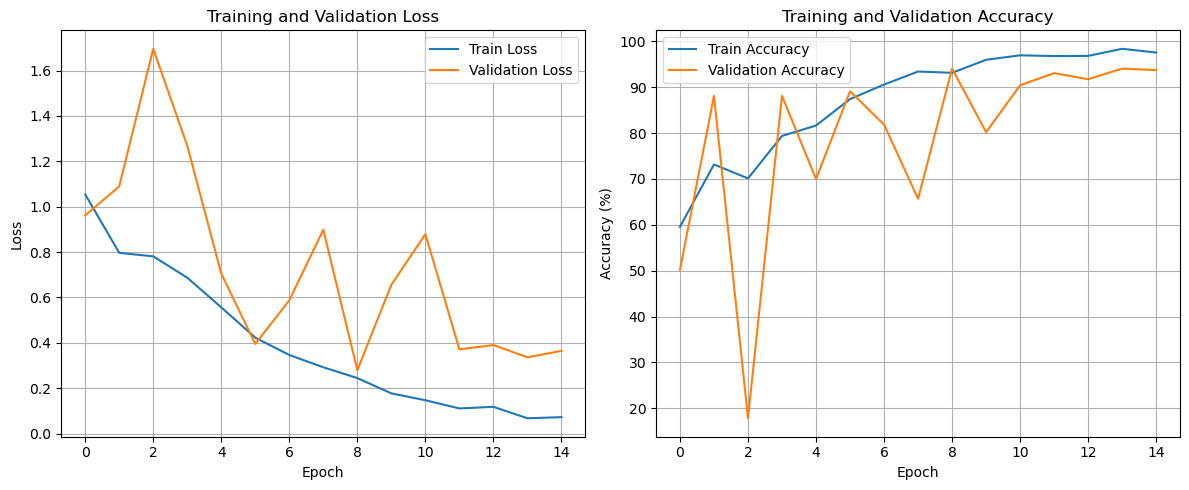

原始混淆矩阵：
      0  1   2
0  267  0   0
1    4  9   7
2    3  3  12 其中列为true label,行为predicted label


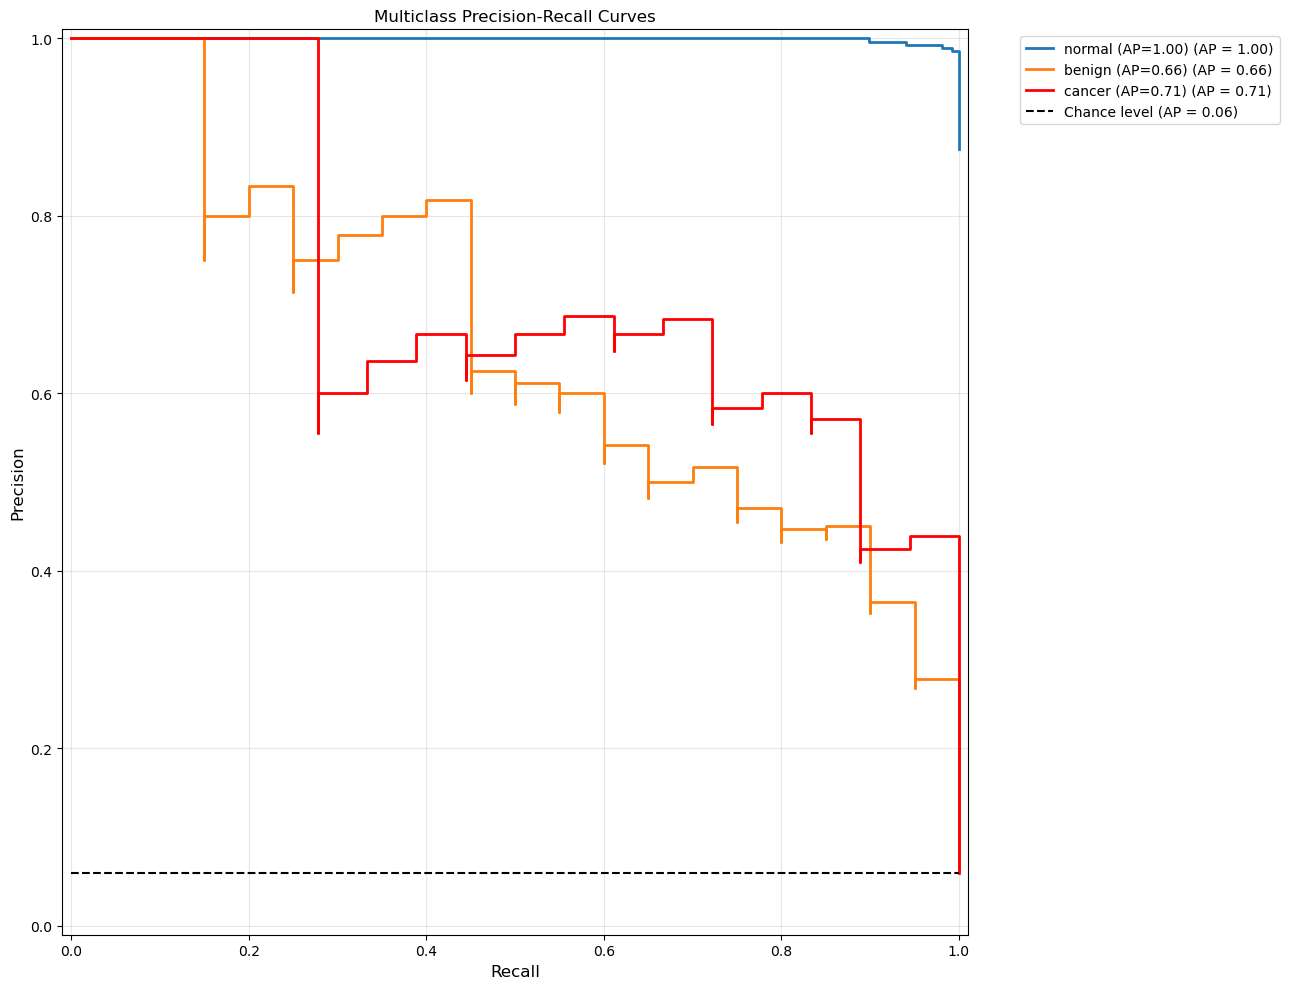

In [17]:
if __name__ == '__main__':
    main()

#######################
可以看出对于少数类别的识别效果和原模型相比也有很大提升，略优于使用过采样的模型结果，能识别出12/18=0.68的cancer类别和9/20=0.45的benign类别。这是目前效果最好的模型。

可以看出，这两种方法都是有明显效果的，从混淆矩阵来看，使用过采样的方法对于少数类别的识别效果略差于对损失函数进行加权，而且对于多数类别的识别效果还要更好。所以我们将进一步对使用过采样的方法进行微调。

我们将进一步提升cancer和benign的样本占比，查看是否能继续提升效果。这次我们将这三个样本数量的比例做到基本一致进行训练，即三个样本均在2000条左右。其他参数不做更改。

原样本数量：cancer:132  normal:2145  benign:186

调整后样本数量：cancer:132\*16=2112  normal:2145  benign:186\*10=1860

同时在进行模型的微调中通过观察发现，修改后的模型基本上在五次左右就已经达到较高的验证集准确率，但是此时继续训练下去准确率会猛降，这可能是因为学习率过高导致的，于是我们将scheduler的步长设定为5，学习率每经过五个epoch就降低一次，以次找到最佳的模型。

下面是调整后的代码：

In [16]:
train_data_oversampled=create_oversampled_dataset(train_data,2,multiplier=16)
train_data_oversampled=create_oversampled_dataset(train_data_oversampled,1,multiplier=10)
train_dataset_oversampled = CancerImageDataset(train_data_oversampled)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
#DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset_oversampled, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



Aftrer oversampleing: Counter({0: 2145, 2: 2112, 1: 186})
Aftrer oversampleing: Counter({0: 2145, 2: 2112, 1: 1860})


In [17]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = CancerImageCNN(num_classes=3).to(device)
    
    # Define the loss function and the optimizer
    
    ################## The loss function is weighted here
    # Extract all labels from the training dataset
    def get_all_labels(dataset):
        return [label for _, label in dataset]

    # Get all labels from the training set
    train_labels = get_all_labels(train_dataset)  # Note: using the original training set without resampling
    # If using resampled dataset, the weights would be approximately equal
    ################## Calculate class weights
    # class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=np.array(train_labels))
    ################## Apply weights in the loss function, note: using the original training set
    # criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ################## Use StepLR to dynamically adjust learning rate during training
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    

    # Training history records
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training parameters
    
    ## Debug settings
    epochs_num = 10  # Reduced number of training epochs
    best_acc = 0.0

    # Training loop
    for epoch in range(1, epochs_num+1):
        start_time = time.time()
        
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        scheduler.step()
        
        # Record historical data
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch}/{epochs_num} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 60)
    
    # Final testing
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    print(f'\nFinal Test Performance:')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    
    # Plot training curves
    plot_training_curves(history)
    
    # Plot confusion matrix and recall-related metrics for predictions
    test_results = get_predictions(model, device, test_loader)
    y_true = test_results['true_labels']  # Array of true labels
    y_pred = test_results['predictions']  # Array of predicted labels
    classes = ['normal','benign','cancer']  # Class names
    cm = confusion_matrix(y_true, y_pred)  # Confusion matrix
    df_cm = pd.DataFrame(cm) 
    
    print("Original confusion matrix:\n", df_cm, "where columns are true labels and rows are predicted labels")
    
    # Plot PR curves for each class
    # Special focus on the 'cancer' class
    y_scores = test_results['probabilities']
    plot_multiclass_pr_curves(y_true, y_scores, classes, focus_class='cancer')

Using device: cuda


Train Epoch 1: 100%|██████████| 192/192 [00:52<00:00,  3.64it/s, loss=0.069, acc=80.8]


Epoch 1/10 | Time: 55.59s
Train Loss: 0.4394 | Train Acc: 80.84%
Val Loss: 2.4936 | Val Acc: 39.27%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 192/192 [01:13<00:00,  2.60it/s, loss=0.0224, acc=95.3]


Epoch 2/10 | Time: 76.35s
Train Loss: 0.1425 | Train Acc: 95.31%
Val Loss: 1.9632 | Val Acc: 41.91%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 192/192 [01:03<00:00,  3.01it/s, loss=0.0155, acc=96.8]


Epoch 3/10 | Time: 67.08s
Train Loss: 0.0986 | Train Acc: 96.78%
Val Loss: 0.8454 | Val Acc: 89.44%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 192/192 [01:13<00:00,  2.63it/s, loss=0.00996, acc=98] 


Epoch 4/10 | Time: 74.90s
Train Loss: 0.0634 | Train Acc: 98.01%
Val Loss: 0.8326 | Val Acc: 76.57%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 192/192 [01:07<00:00,  2.85it/s, loss=0.00617, acc=98.6]


Epoch 5/10 | Time: 68.63s
Train Loss: 0.0393 | Train Acc: 98.59%
Val Loss: 1.8941 | Val Acc: 40.92%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 192/192 [01:00<00:00,  3.19it/s, loss=0.00157, acc=99.7]


Epoch 6/10 | Time: 62.84s
Train Loss: 0.0100 | Train Acc: 99.72%
Val Loss: 0.2178 | Val Acc: 95.05%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 192/192 [00:57<00:00,  3.36it/s, loss=0.000836, acc=99.9]


Epoch 7/10 | Time: 58.54s
Train Loss: 0.0053 | Train Acc: 99.89%
Val Loss: 0.2354 | Val Acc: 95.05%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 192/192 [00:55<00:00,  3.45it/s, loss=0.00069, acc=99.9]


Epoch 8/10 | Time: 56.98s
Train Loss: 0.0044 | Train Acc: 99.89%
Val Loss: 0.2532 | Val Acc: 95.05%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 192/192 [00:51<00:00,  3.73it/s, loss=0.00125, acc=99.9]


Epoch 9/10 | Time: 52.85s
Train Loss: 0.0080 | Train Acc: 99.92%
Val Loss: 0.2319 | Val Acc: 95.05%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 192/192 [00:50<00:00,  3.80it/s, loss=0.00302, acc=99.8]


Epoch 10/10 | Time: 51.86s
Train Loss: 0.0192 | Train Acc: 99.77%
Val Loss: 0.2895 | Val Acc: 94.06%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_29800\3640860496.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.4179 | Test Acc: 92.79%


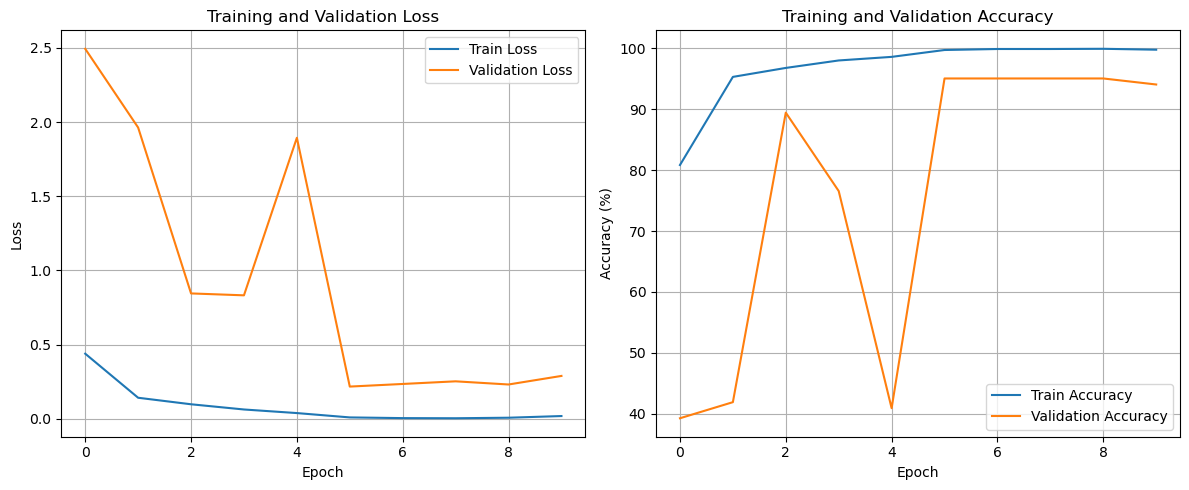

Original confusion matrix:
      0   1  2
0  265   0  2
1    1  10  9
2    0  10  8 where columns are true labels and rows are predicted labels


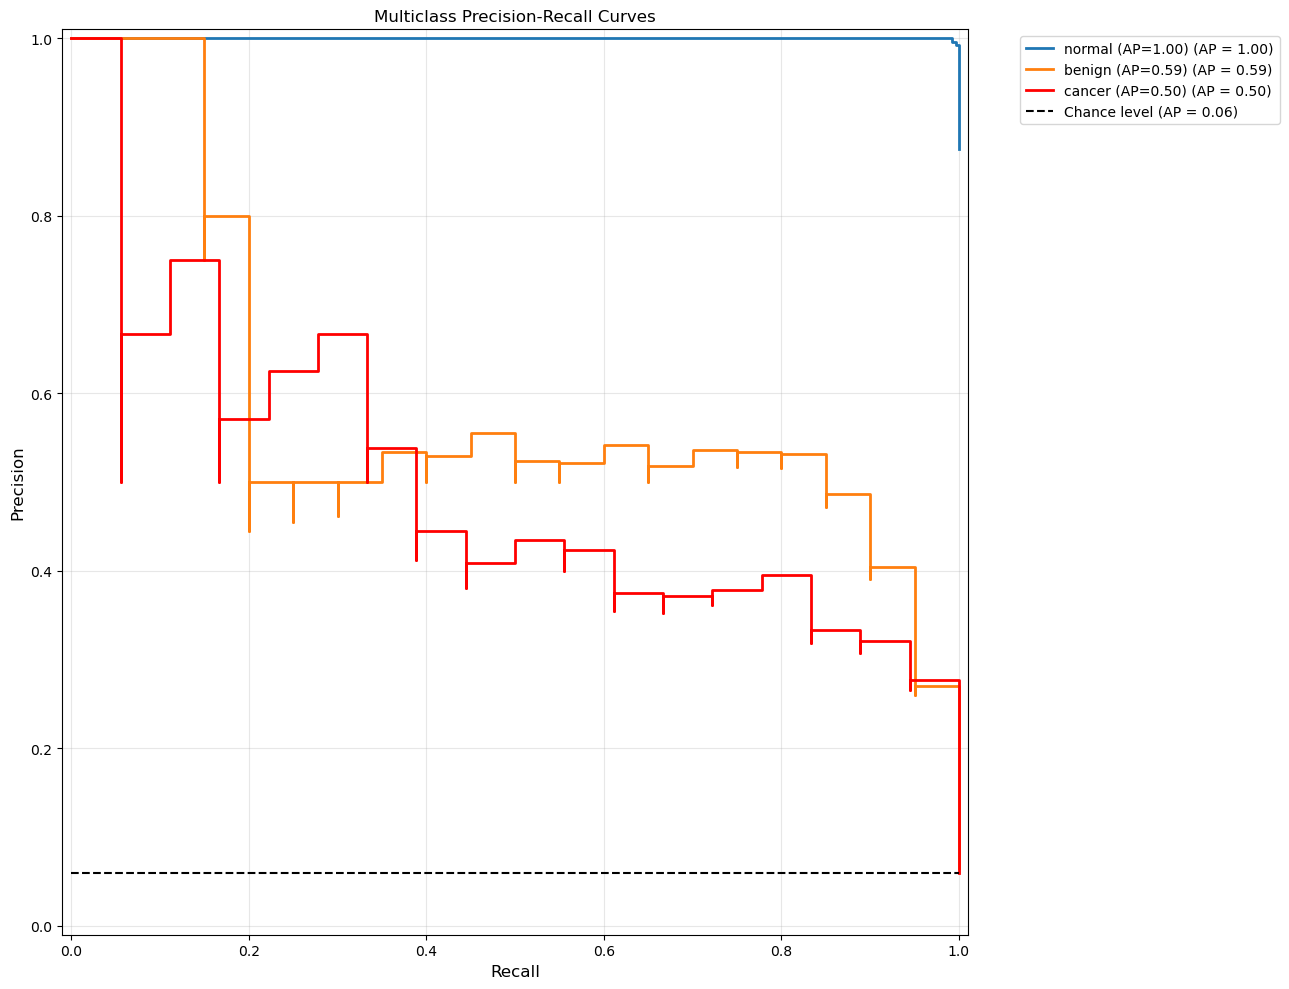

In [18]:
if __name__ == '__main__':
    main()

从上述结果来看效果尚可。cancer和benign的测试集样本只有一个样本被分到了noraml中，这一分类的错误的影响相比未诊断出cancer和benign的影响要小一些。如果将模型改为二分类模型，将cancer和benign并为一类有肿瘤病变(不区分良性还是恶性)，（因为检测到肿瘤病变就要进行活检，活检将会判断病人的肿瘤病变为良性还是恶性。相比将cancer和benign直接分错至normal类别，未诊断出病人身上的问题导致错过治疗时间的后果会好一点）模型的准确率就会达到将近100%，召回率也会接近100%。

## Q2 Implement a transfer learning model based on a pretrained model 

q2要求我们implement a transfer learning model based on a pretrained model (e.g., 
pretrained ResNet-18) and fine-tune it in PyTorch for the classification of the clinical diseases images. 所以本报告选择了基于ResNet-18的迁移学习模型。我们需要保留卷积层等各个层的参数，并将最后的全连接层替换为自定义的输出层，否则是在预训练模型的基础上进行微调，而非从头开始训练。

我们将连接层的输入设置为256，最终输出为3类，dropout层drop参数的概率设置为0.5。

In [34]:
from torchvision import models, transforms

class ResNet18Transfer(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet18Transfer, self).__init__()
        # Load pretrained ResNet18
        self.base_model = models.resnet18(pretrained=True)
        
        # Freeze all convolutional layer parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        # Replace the final fully connected layer
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.base_model(x)

model = ResNet18Transfer(num_classes=3).to(device)

e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


之后我们便可以使用同样的数据集开始进行训练了。我们首先使用过采样平衡过后的训练集和测试集进行训练，并使用测试集进行测试，训练过程与进行的操作与我们自己训练的模型一致。

In [35]:
train_data_oversampled=create_oversampled_dataset(train_data,2,multiplier=16)
train_data_oversampled=create_oversampled_dataset(train_data,1,multiplier=10)
train_dataset_oversampled = CancerImageDataset(train_data_oversampled)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
#DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset_oversampled, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    ##### Changed to ResNet18 transfer learning model
    model = ResNet18Transfer(num_classes=3).to(device)
    
    # Define loss function and optimizer
    
    ################## Weighting the loss function here
    # Extract all labels from training dataset
    def get_all_labels(dataset):
        return [label for _, label in dataset]

    # Get all labels from training set
    #train_labels = get_all_labels(train_dataset)
    ################## Calculate class weights
    #class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=np.array(train_labels))
    ################## Apply weights in loss function
    #criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ################## Use StepLR to dynamically adjust learning rate during training
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    

    # Training history records
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training parameters
    
    ## Debug settings
    epochs_num = 15
    best_acc = 0.0

    # Training loop
    for epoch in range(1, epochs_num+1):
        start_time = time.time()
        
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        scheduler.step()
        
        # Record training history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch}/{epochs_num} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print('-' * 60)
    
    # Final testing
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    print(f'\nFinal Test Performance:')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    
    # Plot training curves
    plot_training_curves(history)
    
    # Plot confusion matrix and recall metrics for predictions
    test_results = get_predictions(model, device, test_loader)
    y_true = test_results['true_labels']  # Array of true labels
    y_pred = test_results['predictions']  # Array of predicted labels
    classes = ['normal','benign','cancer']  # Class names
    cm = confusion_matrix(y_true, y_pred)  # Confusion matrix
    df_cm = pd.DataFrame(cm) 
    
    print("Original confusion matrix:\n", df_cm, "where columns are true labels and rows are predicted labels")
    
    # Plot PR curves for each class
    # Special focus on 'cancer' class
    y_scores = test_results['probabilities']
    plot_multiclass_pr_curves(y_true, y_scores, classes, focus_class='cancer')
    

Using device: cuda


Train Epoch 1: 100%|██████████| 141/141 [00:19<00:00,  7.12it/s, loss=0.441, acc=81.6]


Epoch 1/15 | Time: 21.19s
Train Loss: 0.4864 | Train Acc: 81.64%
Val Loss: 0.3649 | Val Acc: 93.40%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 141/141 [00:19<00:00,  7.27it/s, loss=0.273, acc=90.2]


Epoch 2/15 | Time: 20.69s
Train Loss: 0.3014 | Train Acc: 90.15%
Val Loss: 0.4394 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 141/141 [00:19<00:00,  7.14it/s, loss=0.236, acc=92.1]


Epoch 3/15 | Time: 21.08s
Train Loss: 0.2601 | Train Acc: 92.06%
Val Loss: 0.3347 | Val Acc: 93.40%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 141/141 [00:19<00:00,  7.18it/s, loss=0.213, acc=92.4]


Epoch 4/15 | Time: 20.99s
Train Loss: 0.2348 | Train Acc: 92.44%
Val Loss: 0.3691 | Val Acc: 93.07%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 141/141 [00:19<00:00,  7.22it/s, loss=0.185, acc=93.7]


Epoch 5/15 | Time: 20.84s
Train Loss: 0.2035 | Train Acc: 93.75%
Val Loss: 0.3415 | Val Acc: 92.41%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 141/141 [00:19<00:00,  7.23it/s, loss=0.171, acc=94]  


Epoch 6/15 | Time: 20.80s
Train Loss: 0.1891 | Train Acc: 93.97%
Val Loss: 0.3307 | Val Acc: 93.07%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 141/141 [00:19<00:00,  7.23it/s, loss=0.161, acc=94.3]


Epoch 7/15 | Time: 20.83s
Train Loss: 0.1776 | Train Acc: 94.34%
Val Loss: 0.4010 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 141/141 [00:19<00:00,  7.25it/s, loss=0.163, acc=94.4]


Epoch 8/15 | Time: 20.76s
Train Loss: 0.1803 | Train Acc: 94.39%
Val Loss: 0.3273 | Val Acc: 92.74%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 141/141 [00:19<00:00,  7.22it/s, loss=0.14, acc=95.3] 


Epoch 9/15 | Time: 20.79s
Train Loss: 0.1540 | Train Acc: 95.28%
Val Loss: 0.3436 | Val Acc: 92.74%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 141/141 [00:19<00:00,  7.23it/s, loss=0.14, acc=94.9] 


Epoch 10/15 | Time: 20.81s
Train Loss: 0.1546 | Train Acc: 94.90%
Val Loss: 0.3246 | Val Acc: 92.41%
------------------------------------------------------------


Train Epoch 11: 100%|██████████| 141/141 [00:19<00:00,  7.27it/s, loss=0.136, acc=95.3]


Epoch 11/15 | Time: 20.72s
Train Loss: 0.1503 | Train Acc: 95.30%
Val Loss: 0.3280 | Val Acc: 93.40%
------------------------------------------------------------


Train Epoch 12: 100%|██████████| 141/141 [00:19<00:00,  7.15it/s, loss=0.129, acc=95.5]


Epoch 12/15 | Time: 21.09s
Train Loss: 0.1426 | Train Acc: 95.48%
Val Loss: 0.3162 | Val Acc: 93.73%
------------------------------------------------------------


Train Epoch 13: 100%|██████████| 141/141 [00:19<00:00,  7.26it/s, loss=0.149, acc=94.7]


Epoch 13/15 | Time: 20.77s
Train Loss: 0.1638 | Train Acc: 94.74%
Val Loss: 0.3462 | Val Acc: 92.74%
------------------------------------------------------------


Train Epoch 14: 100%|██████████| 141/141 [00:19<00:00,  7.25it/s, loss=0.129, acc=95.6]


Epoch 14/15 | Time: 20.73s
Train Loss: 0.1417 | Train Acc: 95.59%
Val Loss: 0.3755 | Val Acc: 92.08%
------------------------------------------------------------


Train Epoch 15: 100%|██████████| 141/141 [00:19<00:00,  7.24it/s, loss=0.117, acc=96.1]


Epoch 15/15 | Time: 20.77s
Train Loss: 0.1288 | Train Acc: 96.05%
Val Loss: 0.2999 | Val Acc: 93.40%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_25372\1635607668.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.3361 | Test Acc: 92.13%


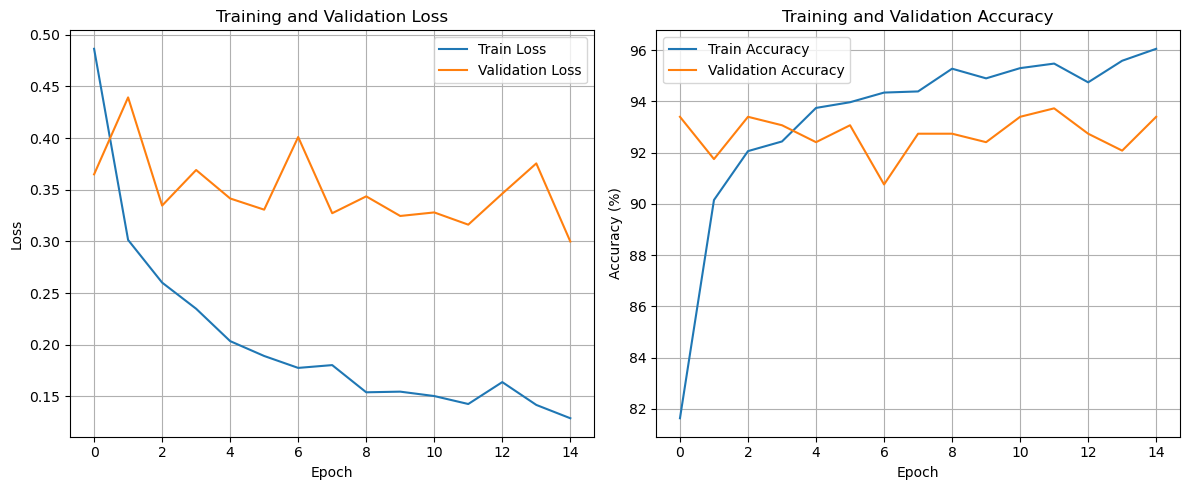

原始混淆矩阵：
      0   1  2
0  262   5  0
1    1  19  0
2    2  16  0 其中列为true label，行为predicted label


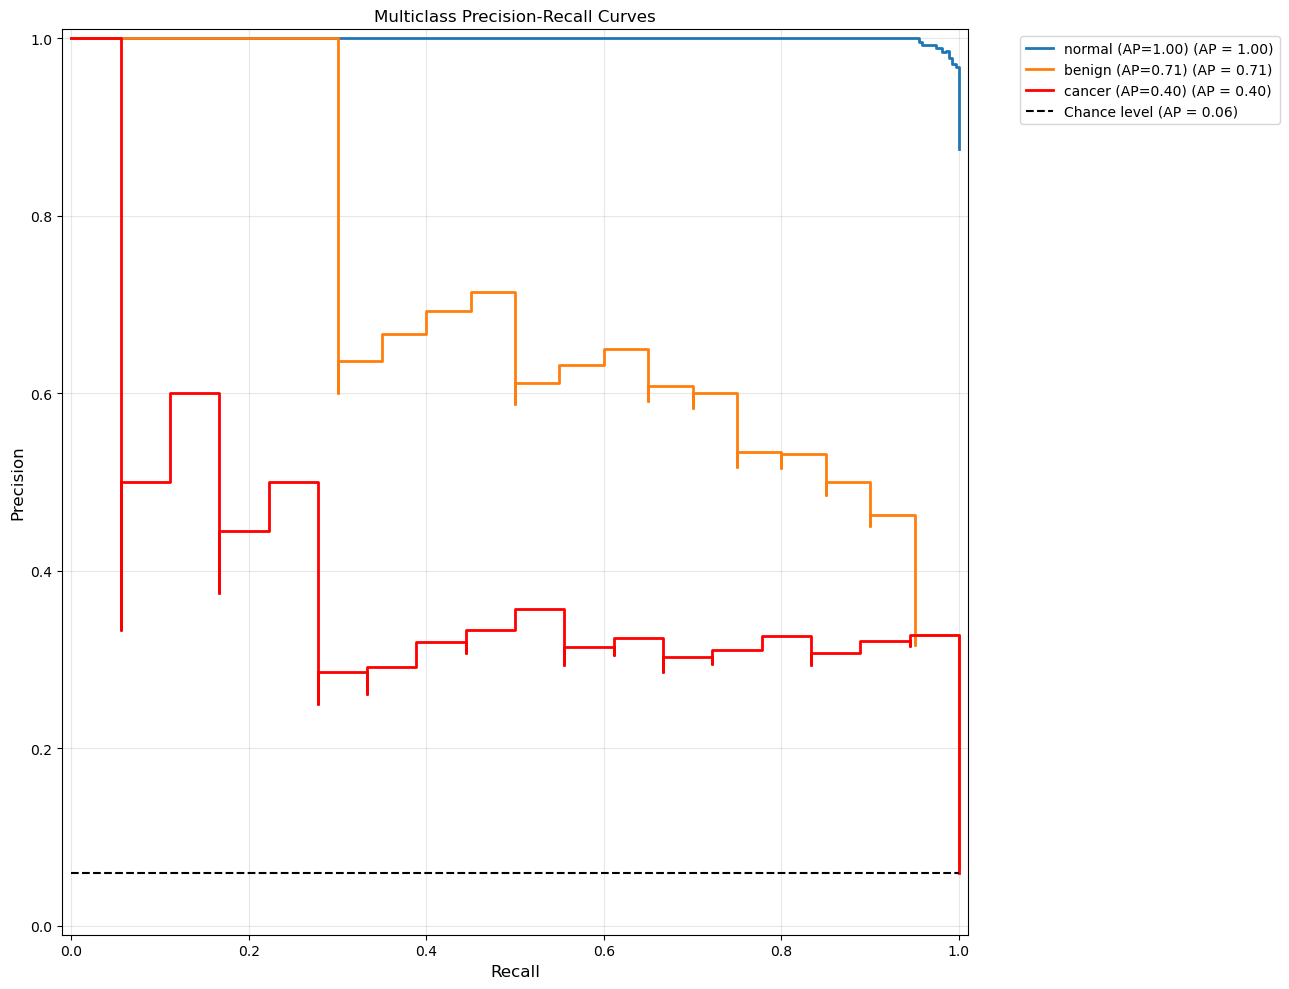

In [36]:
if __name__ == '__main__':
    main()

Using device: cuda


e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Train Epoch 1: 100%|██████████| 143/143 [00:20<00:00,  6.81it/s, loss=0.511, acc=79.3]


Epoch 1/15 | Time: 22.39s
Train Loss: 0.5276 | Train Acc: 79.34%
Val Loss: 0.2930 | Val Acc: 90.43%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 143/143 [00:20<00:00,  6.84it/s, loss=0.388, acc=85.6]


Epoch 2/15 | Time: 22.32s
Train Loss: 0.4002 | Train Acc: 85.57%
Val Loss: 0.3051 | Val Acc: 91.09%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 143/143 [00:20<00:00,  6.87it/s, loss=0.319, acc=88.5]


Epoch 3/15 | Time: 22.23s
Train Loss: 0.3297 | Train Acc: 88.55%
Val Loss: 0.3368 | Val Acc: 88.78%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 143/143 [00:20<00:00,  6.83it/s, loss=0.283, acc=89.9]


Epoch 4/15 | Time: 22.35s
Train Loss: 0.2916 | Train Acc: 89.90%
Val Loss: 0.3220 | Val Acc: 88.12%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 143/143 [00:20<00:00,  6.88it/s, loss=0.263, acc=90.8]


Epoch 5/15 | Time: 22.22s
Train Loss: 0.2714 | Train Acc: 90.75%
Val Loss: 0.2602 | Val Acc: 92.41%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 143/143 [00:20<00:00,  6.89it/s, loss=0.23, acc=91.7] 


Epoch 6/15 | Time: 22.11s
Train Loss: 0.2378 | Train Acc: 91.72%
Val Loss: 0.3010 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 143/143 [00:20<00:00,  7.06it/s, loss=0.2, acc=93.2]  


Epoch 7/15 | Time: 21.57s
Train Loss: 0.2063 | Train Acc: 93.18%
Val Loss: 0.2772 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 143/143 [00:20<00:00,  7.11it/s, loss=0.201, acc=93.3]


Epoch 8/15 | Time: 21.43s
Train Loss: 0.2070 | Train Acc: 93.27%
Val Loss: 0.2585 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 143/143 [00:20<00:00,  7.09it/s, loss=0.193, acc=93]  


Epoch 9/15 | Time: 21.49s
Train Loss: 0.1997 | Train Acc: 93.05%
Val Loss: 0.2503 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 143/143 [00:20<00:00,  7.13it/s, loss=0.183, acc=93.2]


Epoch 10/15 | Time: 21.37s
Train Loss: 0.1884 | Train Acc: 93.22%
Val Loss: 0.3243 | Val Acc: 90.10%
------------------------------------------------------------


Train Epoch 11: 100%|██████████| 143/143 [00:20<00:00,  7.11it/s, loss=0.172, acc=94.1]


Epoch 11/15 | Time: 21.46s
Train Loss: 0.1780 | Train Acc: 94.05%
Val Loss: 0.2408 | Val Acc: 91.42%
------------------------------------------------------------


Train Epoch 12: 100%|██████████| 143/143 [00:20<00:00,  7.12it/s, loss=0.156, acc=94.7]


Epoch 12/15 | Time: 21.47s
Train Loss: 0.1610 | Train Acc: 94.73%
Val Loss: 0.2558 | Val Acc: 91.42%
------------------------------------------------------------


Train Epoch 13: 100%|██████████| 143/143 [00:19<00:00,  7.19it/s, loss=0.138, acc=95.2]


Epoch 13/15 | Time: 21.21s
Train Loss: 0.1421 | Train Acc: 95.19%
Val Loss: 0.2598 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 14: 100%|██████████| 143/143 [00:19<00:00,  7.20it/s, loss=0.144, acc=94.9]


Epoch 14/15 | Time: 21.19s
Train Loss: 0.1488 | Train Acc: 94.91%
Val Loss: 0.2890 | Val Acc: 90.43%
------------------------------------------------------------


Train Epoch 15: 100%|██████████| 143/143 [00:19<00:00,  7.19it/s, loss=0.147, acc=95.1]


Epoch 15/15 | Time: 21.24s
Train Loss: 0.1516 | Train Acc: 95.13%
Val Loss: 0.2484 | Val Acc: 91.75%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_25372\1635607668.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.2662 | Test Acc: 88.85%


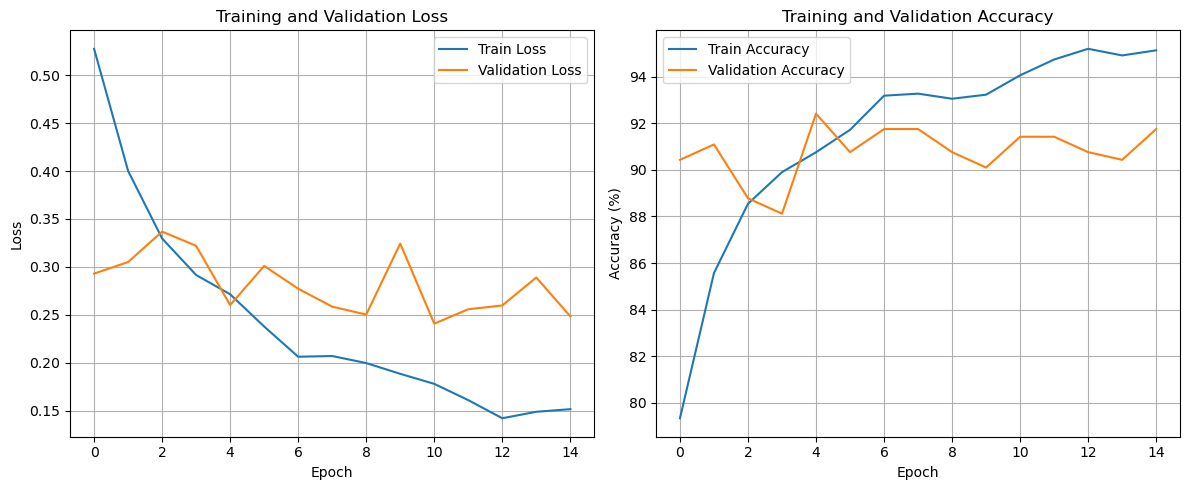

原始混淆矩阵：
      0  1   2
0  256  0  11
1    3  0  17
2    3  0  15 其中列为true label，行为predicted label


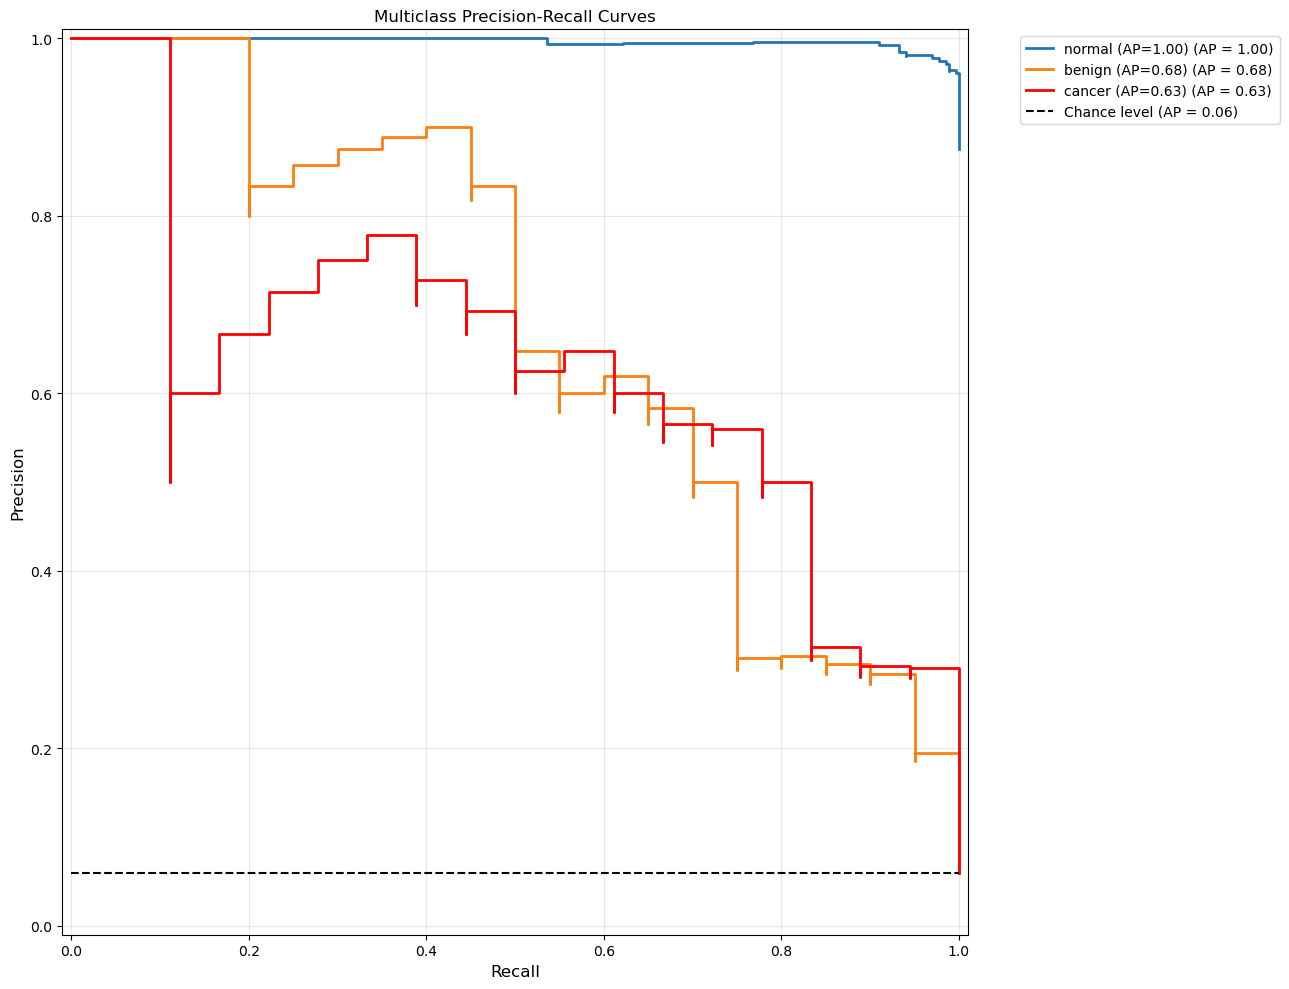

In [40]:
train_data_oversampled=create_oversampled_dataset(train_data,2,multiplier=16)
train_dataset_oversampled = CancerImageDataset(train_data_oversampled)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
#DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset_oversampled, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

if __name__ == '__main__':
    main()

In [ ]:
train_data_oversampled=create_oversampled_dataset(train_data,2,multiplier=16)
train_dataset_oversampled = CancerImageDataset(train_data_oversampled)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
#DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset_oversampled, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

if __name__ == '__main__':
    main()

从混淆矩阵可以看出，模型此时又对cancer过拟合了，把benign的样本都预测成了cancer，我们接下来降低cancer的样本数量进行测试。

Using device: cuda


e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Train Epoch 1: 100%|██████████| 98/98 [00:14<00:00,  6.94it/s, loss=0.354, acc=76.8]


Epoch 1/15 | Time: 15.55s
Train Loss: 0.5946 | Train Acc: 76.82%
Val Loss: 0.3632 | Val Acc: 90.10%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 98/98 [00:13<00:00,  7.03it/s, loss=0.246, acc=84.9]


Epoch 2/15 | Time: 15.31s
Train Loss: 0.4131 | Train Acc: 84.89%
Val Loss: 0.2770 | Val Acc: 91.42%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 98/98 [00:13<00:00,  7.05it/s, loss=0.235, acc=85]  


Epoch 3/15 | Time: 15.20s
Train Loss: 0.3949 | Train Acc: 84.98%
Val Loss: 0.2654 | Val Acc: 91.42%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 98/98 [00:13<00:00,  7.08it/s, loss=0.19, acc=88.2] 


Epoch 4/15 | Time: 15.26s
Train Loss: 0.3188 | Train Acc: 88.25%
Val Loss: 0.2590 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 98/98 [00:13<00:00,  7.08it/s, loss=0.184, acc=88.1]


Epoch 5/15 | Time: 15.16s
Train Loss: 0.3082 | Train Acc: 88.09%
Val Loss: 0.3164 | Val Acc: 89.11%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s, loss=0.153, acc=90.6]


Epoch 6/15 | Time: 15.03s
Train Loss: 0.2565 | Train Acc: 90.62%
Val Loss: 0.2392 | Val Acc: 92.08%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 98/98 [00:13<00:00,  7.16it/s, loss=0.149, acc=91]  


Epoch 7/15 | Time: 14.97s
Train Loss: 0.2502 | Train Acc: 91.00%
Val Loss: 0.2254 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s, loss=0.157, acc=90.2]


Epoch 8/15 | Time: 14.95s
Train Loss: 0.2629 | Train Acc: 90.23%
Val Loss: 0.2636 | Val Acc: 91.09%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 98/98 [00:13<00:00,  7.17it/s, loss=0.146, acc=90.7]


Epoch 9/15 | Time: 14.95s
Train Loss: 0.2452 | Train Acc: 90.68%
Val Loss: 0.2196 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 98/98 [00:13<00:00,  7.13it/s, loss=0.132, acc=91.8]


Epoch 10/15 | Time: 15.06s
Train Loss: 0.2217 | Train Acc: 91.83%
Val Loss: 0.2228 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 11: 100%|██████████| 98/98 [00:13<00:00,  7.16it/s, loss=0.124, acc=91.6]


Epoch 11/15 | Time: 15.01s
Train Loss: 0.2087 | Train Acc: 91.61%
Val Loss: 0.2140 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 12: 100%|██████████| 98/98 [00:13<00:00,  7.04it/s, loss=0.118, acc=92.3]


Epoch 12/15 | Time: 15.23s
Train Loss: 0.1982 | Train Acc: 92.32%
Val Loss: 0.2257 | Val Acc: 91.42%
------------------------------------------------------------


Train Epoch 13: 100%|██████████| 98/98 [00:13<00:00,  7.10it/s, loss=0.12, acc=92.4] 


Epoch 13/15 | Time: 15.11s
Train Loss: 0.2008 | Train Acc: 92.41%
Val Loss: 0.2219 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 14: 100%|██████████| 98/98 [00:13<00:00,  7.20it/s, loss=0.12, acc=92.4] 


Epoch 14/15 | Time: 15.00s
Train Loss: 0.2008 | Train Acc: 92.38%
Val Loss: 0.2148 | Val Acc: 92.41%
------------------------------------------------------------


Train Epoch 15: 100%|██████████| 98/98 [00:13<00:00,  7.11it/s, loss=0.116, acc=92.9]


Epoch 15/15 | Time: 15.09s
Train Loss: 0.1943 | Train Acc: 92.92%
Val Loss: 0.2530 | Val Acc: 91.09%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_25372\1635607668.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.2216 | Test Acc: 91.80%


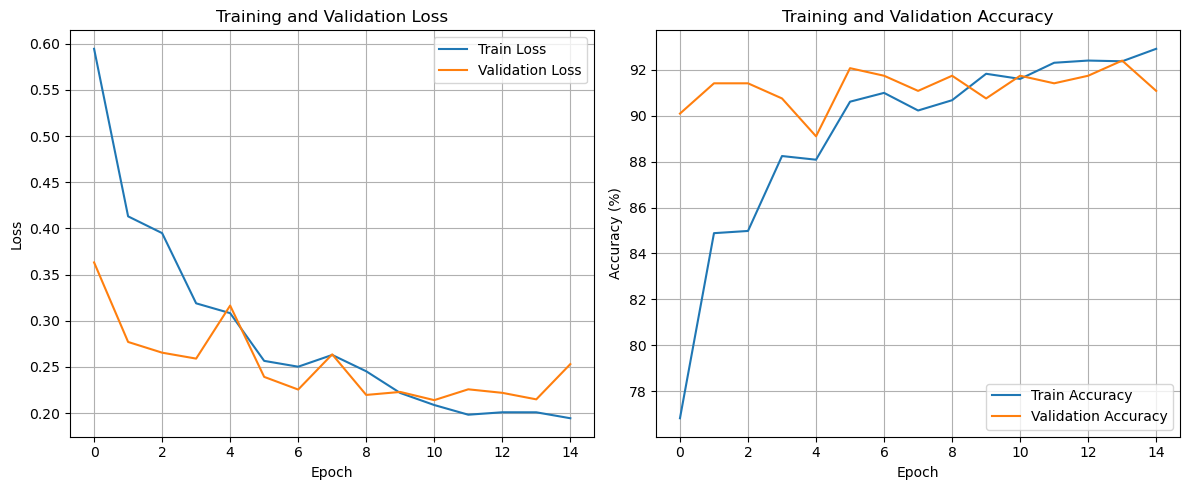

原始混淆矩阵：
      0  1   2
0  259  0   8
1    2  7  11
2    3  1  14 其中列为true label，行为predicted label


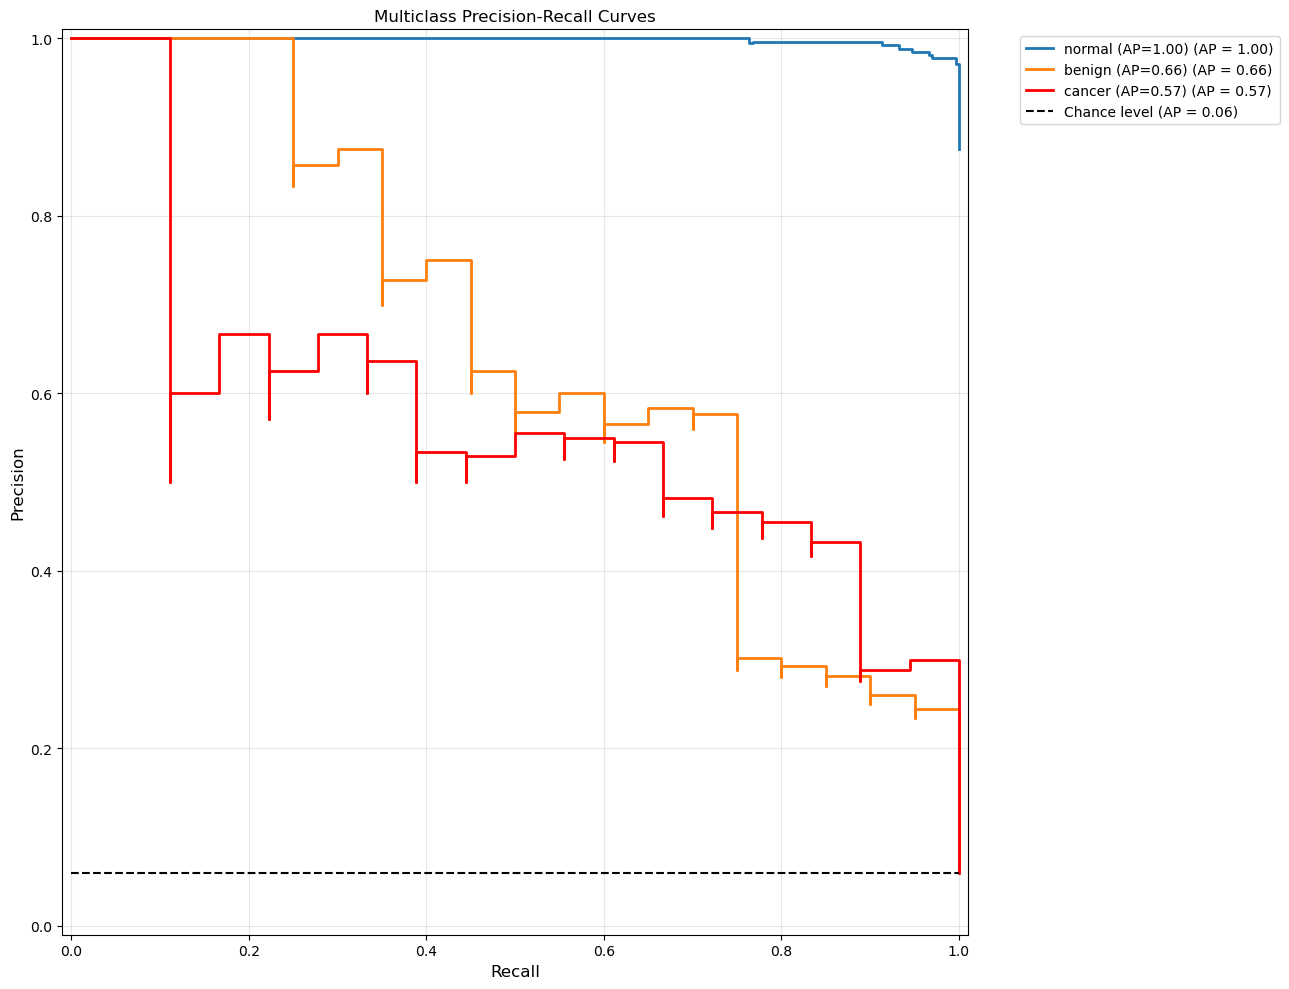

In [41]:
train_data_oversampled=create_oversampled_dataset(train_data,2,multiplier=5)
train_dataset_oversampled = CancerImageDataset(train_data_oversampled)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
#DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset_oversampled, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

if __name__ == '__main__':
    main()

通过平衡过采样倍数的调整，我们得到了一个较优的模型，该模型对cancer的分类效果较好，准确率为78%，在测试集上的总准确率达到了91%。相比之前的模型比较，benign的准确率也提高了，达到了50%。但是总体通过过采样来提升对少数类的效果不如我们自己设计的模型
之后我们将对损失函数进行加权来测试。

In [50]:
# Reset to the original training datasets
train_dataset = CancerImageDataset(train_data)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Test one batch of data
sample_images, sample_labels = next(iter(train_loader))
print(f"img_tensor_shape: {sample_images.shape}")  # Expected shape: [32, 3, 224, 224]
print(f"label_tensor_shape: {sample_labels.shape}")  # Expected shape: [32]

img_tensor_shape: torch.Size([32, 3, 256, 256])
label_tensor_shape: torch.Size([32])


Using device: cuda


Train Epoch 1: 100%|██████████| 77/77 [00:11<00:00,  6.89it/s, loss=1.06, acc=61.4]


Epoch 1/15 | Time: 12.57s
Train Loss: 1.0944 | Train Acc: 61.39%
Val Loss: 0.5573 | Val Acc: 90.10%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 77/77 [00:10<00:00,  7.01it/s, loss=0.841, acc=77]  


Epoch 2/15 | Time: 12.40s
Train Loss: 0.8674 | Train Acc: 76.98%
Val Loss: 0.4416 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 77/77 [00:11<00:00,  6.99it/s, loss=0.732, acc=80.3]


Epoch 3/15 | Time: 12.34s
Train Loss: 0.7550 | Train Acc: 80.27%
Val Loss: 0.5031 | Val Acc: 82.18%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 77/77 [00:11<00:00,  6.93it/s, loss=0.678, acc=83.1]


Epoch 4/15 | Time: 12.40s
Train Loss: 0.6993 | Train Acc: 83.07%
Val Loss: 0.3447 | Val Acc: 88.78%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 77/77 [00:10<00:00,  7.06it/s, loss=0.654, acc=84]  


Epoch 5/15 | Time: 12.34s
Train Loss: 0.6749 | Train Acc: 83.96%
Val Loss: 0.3054 | Val Acc: 91.42%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 77/77 [00:11<00:00,  6.98it/s, loss=0.602, acc=86.8]


Epoch 6/15 | Time: 12.35s
Train Loss: 0.6217 | Train Acc: 86.85%
Val Loss: 0.3054 | Val Acc: 91.09%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 77/77 [00:10<00:00,  7.05it/s, loss=0.554, acc=88.2]


Epoch 7/15 | Time: 12.27s
Train Loss: 0.5718 | Train Acc: 88.23%
Val Loss: 0.3199 | Val Acc: 90.43%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 77/77 [00:11<00:00,  6.98it/s, loss=0.549, acc=88.4]


Epoch 8/15 | Time: 12.36s
Train Loss: 0.5660 | Train Acc: 88.39%
Val Loss: 0.3496 | Val Acc: 89.11%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 77/77 [00:10<00:00,  7.05it/s, loss=0.51, acc=89.1] 


Epoch 9/15 | Time: 12.31s
Train Loss: 0.5261 | Train Acc: 89.12%
Val Loss: 0.2670 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 77/77 [00:10<00:00,  7.01it/s, loss=0.521, acc=89.4]


Epoch 10/15 | Time: 12.32s
Train Loss: 0.5371 | Train Acc: 89.36%
Val Loss: 0.3375 | Val Acc: 88.78%
------------------------------------------------------------


Train Epoch 11: 100%|██████████| 77/77 [00:10<00:00,  7.06it/s, loss=0.498, acc=89.6]


Epoch 11/15 | Time: 12.20s
Train Loss: 0.5141 | Train Acc: 89.57%
Val Loss: 0.2936 | Val Acc: 91.75%
------------------------------------------------------------


Train Epoch 12: 100%|██████████| 77/77 [00:10<00:00,  7.04it/s, loss=0.495, acc=89.9]


Epoch 12/15 | Time: 12.24s
Train Loss: 0.5107 | Train Acc: 89.93%
Val Loss: 0.2827 | Val Acc: 91.09%
------------------------------------------------------------


Train Epoch 13: 100%|██████████| 77/77 [00:11<00:00,  6.92it/s, loss=0.481, acc=89.9]


Epoch 13/15 | Time: 12.45s
Train Loss: 0.4965 | Train Acc: 89.89%
Val Loss: 0.2869 | Val Acc: 91.09%
------------------------------------------------------------


Train Epoch 14: 100%|██████████| 77/77 [00:11<00:00,  6.94it/s, loss=0.484, acc=90]  


Epoch 14/15 | Time: 12.42s
Train Loss: 0.4995 | Train Acc: 90.01%
Val Loss: 0.3175 | Val Acc: 90.10%
------------------------------------------------------------


Train Epoch 15: 100%|██████████| 77/77 [00:10<00:00,  7.05it/s, loss=0.466, acc=91.6]


Epoch 15/15 | Time: 12.23s
Train Loss: 0.4805 | Train Acc: 91.60%
Val Loss: 0.3074 | Val Acc: 90.76%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_25372\2827098649.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.3262 | Test Acc: 87.87%


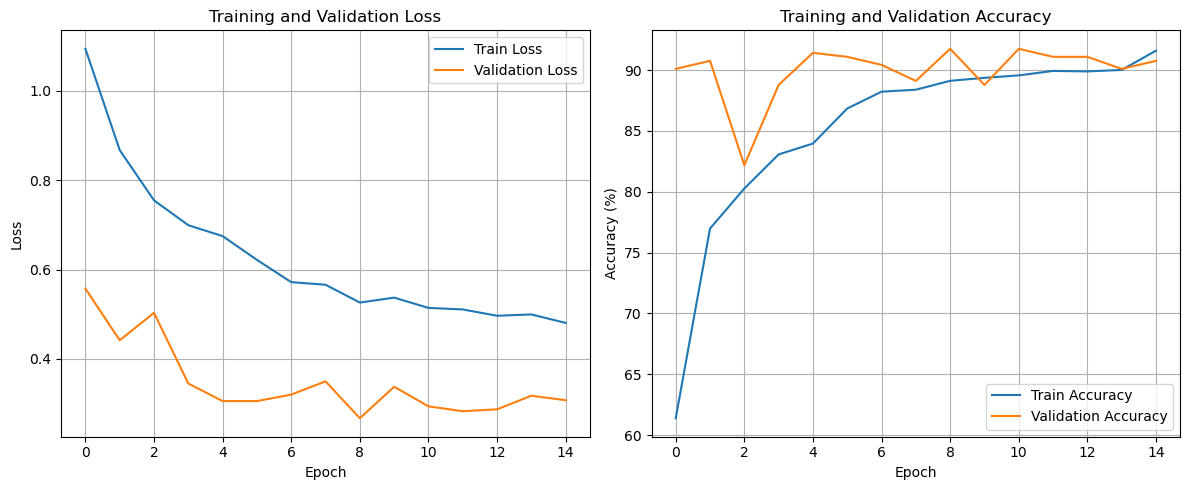

原始混淆矩阵：
      0   1  2
0  249   9  9
1    1  13  6
2    3   9  6 其中列为true label,行为predicted label


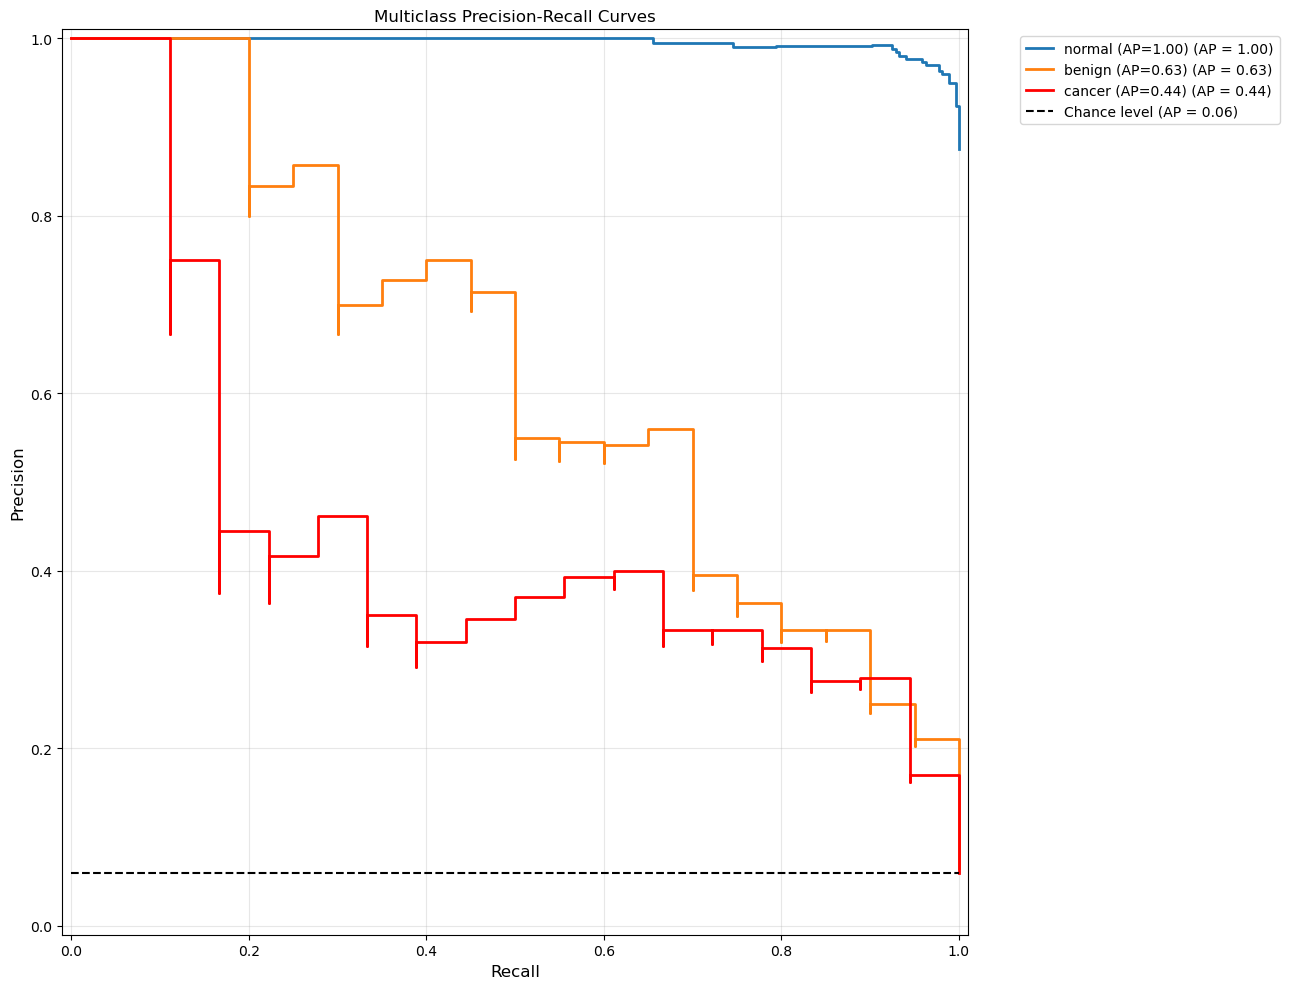

In [51]:
from sklearn.utils.class_weight import compute_class_weight

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = ResNet18Transfer(num_classes=3).to(device)
    
    # Define loss function and optimizer
    
    ################## Apply class weighting to loss function
    # Extract all labels from training dataset
    def get_all_labels(dataset):
        return [label for _, label in dataset]

    # Get all labels from training set
    train_labels = get_all_labels(train_dataset)  # Note: using original non-resampled training set
    # If using resampled dataset, the weights would be approximately equal
    ################## Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=np.array(train_labels))
    ################## Apply weights in loss function (using original non-resampled set)
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    #criterion = nn.CrossEntropyLoss()  # Unweighted alternative
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ################## Use StepLR for dynamic learning rate adjustment
    scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
    
    # Training history records
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training parameters
    ## Debug settings
    epochs_num = 15
    best_acc = 0.0

    # Training loop
    for epoch in range(1, epochs_num+1):
        start_time = time.time()
        
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        scheduler.step()
        
        # Record training metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch}/{epochs_num} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%')
        print(f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%')
        print('-' * 60)
    
    # Final evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    print(f'\nFinal Test Performance:')
    print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%')
    
    # Plot training curves
    plot_training_curves(history)
    
    # Generate and analyze prediction results
    test_results = get_predictions(model, device, test_loader)
    y_true = test_results['true_labels']  # Ground truth labels
    y_pred = test_results['predictions']  # Predicted labels
    classes = ['normal','benign','cancer']  # Class names
    cm = confusion_matrix(y_true, y_pred)  # Confusion matrix
    df_cm = pd.DataFrame(cm) 
    
    print("Confusion Matrix:\n", df_cm, "where columns are true labels and rows are predicted labels")
    
    # Plot PR curves for each class
    # Special focus on 'cancer' class
    y_scores = test_results['probabilities']
    plot_multiclass_pr_curves(y_true, y_scores, classes, focus_class='cancer')

if __name__ == '__main__':
    main()

从上述结果中可以看出，在其他处理一致的情况下，使用ResNet18TransferzuNet进行训练的结果比自己写的模型要略差一些，对于少数类别的识别分类也有所欠缺，训练集中有仅有33%的cancer被成功识别了，对于benign类别的识别水平尚可，达到了65%。从precision-recall曲线上看，ResNet18TransferzuNet的召回率略差于我们自己调试过的模型。这说明我们需要从其他角度来提升ResNet18TransferzuNet。最后我们查看一下不进行任何处理的ResNet18的结果来查找一些原因。

img_tensor_shape: torch.Size([32, 3, 256, 256])
label_tensor_shape: torch.Size([32])
Using device: cuda


e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anna\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Train Epoch 1: 100%|██████████| 77/77 [00:11<00:00,  6.53it/s, loss=0.435, acc=86.6]


Epoch 1/15 | Time: 13.25s
Train Loss: 0.4486 | Train Acc: 86.64%
Val Loss: 0.3878 | Val Acc: 88.12%
------------------------------------------------------------


Train Epoch 2: 100%|██████████| 77/77 [00:11<00:00,  6.58it/s, loss=0.322, acc=87.8]


Epoch 2/15 | Time: 13.12s
Train Loss: 0.3318 | Train Acc: 87.82%
Val Loss: 0.3410 | Val Acc: 90.43%
------------------------------------------------------------


Train Epoch 3: 100%|██████████| 77/77 [00:11<00:00,  6.63it/s, loss=0.269, acc=88.8]


Epoch 3/15 | Time: 12.97s
Train Loss: 0.2776 | Train Acc: 88.75%
Val Loss: 0.2906 | Val Acc: 89.44%
------------------------------------------------------------


Train Epoch 4: 100%|██████████| 77/77 [00:11<00:00,  6.69it/s, loss=0.242, acc=90.3]


Epoch 4/15 | Time: 12.97s
Train Loss: 0.2492 | Train Acc: 90.34%
Val Loss: 0.2764 | Val Acc: 90.76%
------------------------------------------------------------


Train Epoch 5: 100%|██████████| 77/77 [00:11<00:00,  6.59it/s, loss=0.215, acc=90.7]


Epoch 5/15 | Time: 13.12s
Train Loss: 0.2222 | Train Acc: 90.74%
Val Loss: 0.2353 | Val Acc: 93.73%
------------------------------------------------------------


Train Epoch 6: 100%|██████████| 77/77 [00:11<00:00,  6.65it/s, loss=0.217, acc=91.6]


Epoch 6/15 | Time: 12.91s
Train Loss: 0.2242 | Train Acc: 91.60%
Val Loss: 0.2395 | Val Acc: 93.40%
------------------------------------------------------------


Train Epoch 7: 100%|██████████| 77/77 [00:11<00:00,  6.71it/s, loss=0.198, acc=92.6]


Epoch 7/15 | Time: 12.84s
Train Loss: 0.2039 | Train Acc: 92.57%
Val Loss: 0.2365 | Val Acc: 92.74%
------------------------------------------------------------


Train Epoch 8: 100%|██████████| 77/77 [00:11<00:00,  6.50it/s, loss=0.195, acc=92.4]


Epoch 8/15 | Time: 13.21s
Train Loss: 0.2012 | Train Acc: 92.37%
Val Loss: 0.2156 | Val Acc: 93.40%
------------------------------------------------------------


Train Epoch 9: 100%|██████████| 77/77 [00:11<00:00,  6.88it/s, loss=0.188, acc=92.4]


Epoch 9/15 | Time: 12.65s
Train Loss: 0.1938 | Train Acc: 92.45%
Val Loss: 0.2133 | Val Acc: 94.06%
------------------------------------------------------------


Train Epoch 10: 100%|██████████| 77/77 [00:11<00:00,  6.95it/s, loss=0.174, acc=93.3]


Epoch 10/15 | Time: 12.41s
Train Loss: 0.1791 | Train Acc: 93.26%
Val Loss: 0.2184 | Val Acc: 94.06%
------------------------------------------------------------


Train Epoch 11: 100%|██████████| 77/77 [00:10<00:00,  7.01it/s, loss=0.173, acc=93]  


Epoch 11/15 | Time: 12.35s
Train Loss: 0.1785 | Train Acc: 93.02%
Val Loss: 0.2141 | Val Acc: 94.06%
------------------------------------------------------------


Train Epoch 12: 100%|██████████| 77/77 [00:11<00:00,  6.84it/s, loss=0.178, acc=93.1]


Epoch 12/15 | Time: 12.59s
Train Loss: 0.1840 | Train Acc: 93.06%
Val Loss: 0.2039 | Val Acc: 94.06%
------------------------------------------------------------


Train Epoch 13: 100%|██████████| 77/77 [00:11<00:00,  6.99it/s, loss=0.174, acc=93.5]


Epoch 13/15 | Time: 12.35s
Train Loss: 0.1800 | Train Acc: 93.54%
Val Loss: 0.2070 | Val Acc: 94.06%
------------------------------------------------------------


Train Epoch 14: 100%|██████████| 77/77 [00:10<00:00,  7.07it/s, loss=0.171, acc=93.5]


Epoch 14/15 | Time: 12.27s
Train Loss: 0.1762 | Train Acc: 93.50%
Val Loss: 0.2104 | Val Acc: 93.73%
------------------------------------------------------------


Train Epoch 15: 100%|██████████| 77/77 [00:10<00:00,  7.07it/s, loss=0.169, acc=93.7]


Epoch 15/15 | Time: 12.25s
Train Loss: 0.1743 | Train Acc: 93.71%
Val Loss: 0.2124 | Val Acc: 93.73%
------------------------------------------------------------


C:\Users\zhuanghuo\AppData\Local\Temp;\ipykernel_25372\3097833542.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Performance:
Test Loss: 0.2551 | Test Acc: 92.46%


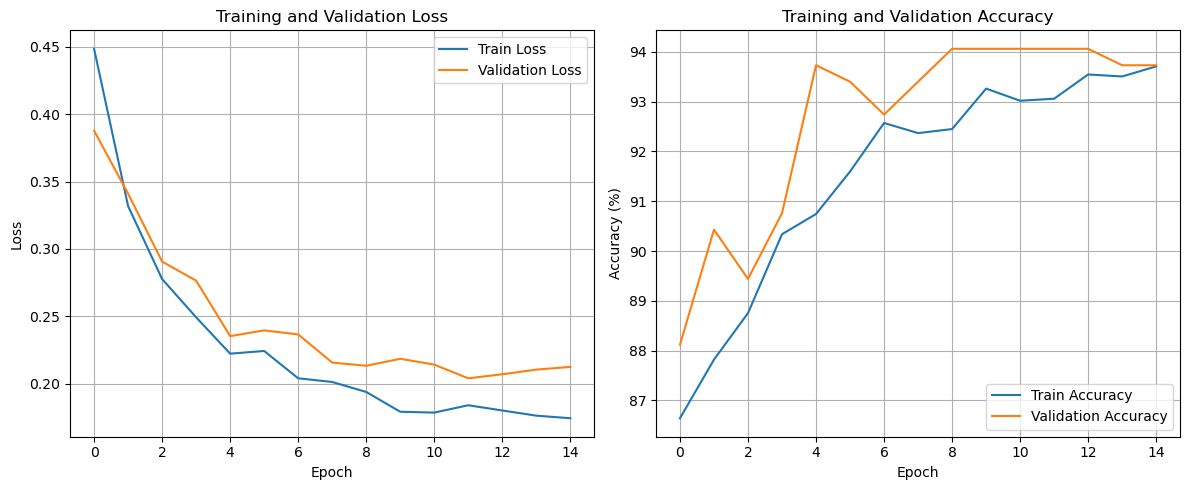

原始混淆矩阵：
      0   1  2
0  266   1  0
1    5  13  2
2    4  11  3 其中列为true label,行为predicted label


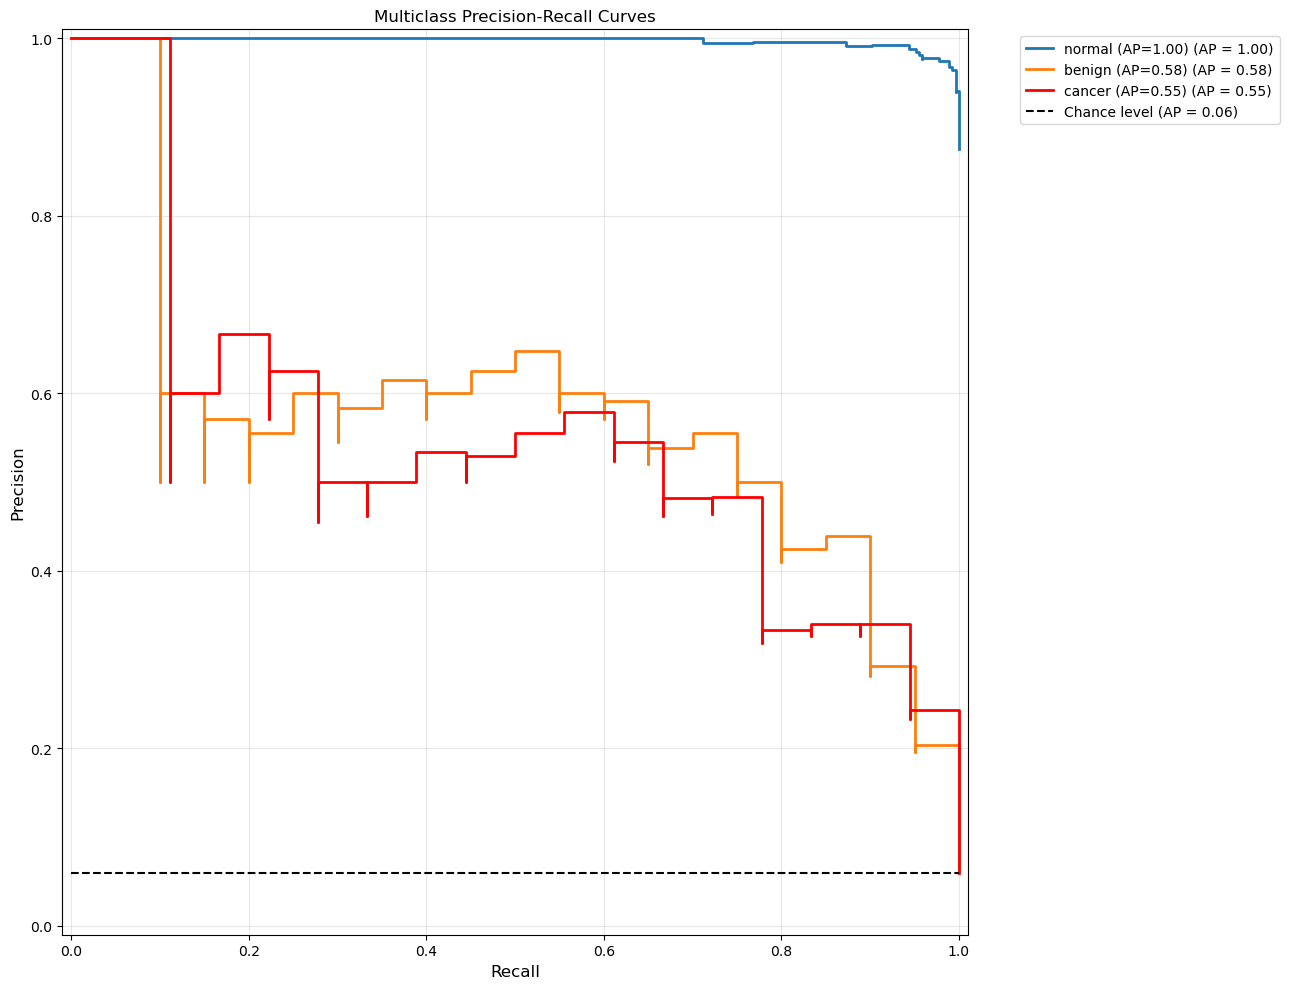

In [53]:
### Back to original dataset
train_dataset = CancerImageDataset(train_data)
val_dataset = CancerImageDataset(val_data)
test_dataset = CancerImageDataset(test_data)
    
# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#Test the DataLoader
sample_images, sample_labels = next(iter(train_loader))
print(f"img_tensor_shape: {sample_images.shape}")  # 应为 [32, 3, 224, 224]
print(f"label_tensor_shape: {sample_labels.shape}")  # 应为 [32]



def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = ResNet18Transfer(num_classes=3).to(device)
    
    # Define loss function and optimizer
    
    ################## Apply class weighting to loss function
    # Extract all labels from training dataset
    def get_all_labels(dataset):
        return [label for _, label in dataset]

    # Get all labels from training set
    train_labels = get_all_labels(train_dataset)  # Note: using original non-resampled training set
    # If using resampled dataset, the weights would be approximately equal
    ################## Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=np.array(train_labels))
    ################## Apply weights in loss function (using original non-resampled set)
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    #criterion = nn.CrossEntropyLoss()  # Unweighted alternative
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ################## Use StepLR for dynamic learning rate adjustment
    scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
    
    # Training history records
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training parameters
    ## Debug settings
    epochs_num = 15
    best_acc = 0.0

    # Training loop
    for epoch in range(1, epochs_num+1):
        start_time = time.time()
        
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        scheduler.step()
        
        # Record training metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch}/{epochs_num} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%')
        print(f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%')
        print('-' * 60)
    
    # Final evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    print(f'\nFinal Test Performance:')
    print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%')
    
    # Plot training curves
    plot_training_curves(history)
    
    # Generate and analyze prediction results
    test_results = get_predictions(model, device, test_loader)
    y_true = test_results['true_labels']  # Ground truth labels
    y_pred = test_results['predictions']  # Predicted labels
    classes = ['normal','benign','cancer']  # Class names
    cm = confusion_matrix(y_true, y_pred)  # Confusion matrix
    df_cm = pd.DataFrame(cm) 
    
    print("Confusion Matrix:\n", df_cm, "where columns are true labels and rows are predicted labels")
    
    # Plot PR curves for each class
    # Special focus on 'cancer' class
    y_scores = test_results['probabilities']
    plot_multiclass_pr_curves(y_true, y_scores, classes, focus_class='cancer')

if __name__ == '__main__':
    main()

最后发现对少数类的识别结果甚至比和经过过采样或者加权损失函数的模型略优，说明ResNet18的泛化能力还是很强的。造成这种情况的原因可能是因为cancer和benign的数据深度不够，训练集包含的特征不足支撑模型的泛化能力。对于某些医学图像任务，简单的经典模型+充足预训练可能比复杂的类别平衡策略更有效。从中可以看出，ResNet的强特征提取能力迁移学习具有一定的优势。使用预训练的ResNet18，其在大规模数据集上学到的通用特征提取能力可能比从零训练的CNN更强。而且残差连接帮助网络更好地学习多尺度特征，这对小样本类别尤其重要。所以即使不进行重抽样或对损失函数进行加权，也能达到较好的效果。